# Bursting The Bubble
COMP-4447: Data Science Tools 1<br>
Final Project<br>
November 14, 2022<br>
Sammantha Firestone, Jacquelyn Noyes

## Purpose
Currently in the United States, one of the largest economic barriers that exists is the unaffordability of housing. Historically, the average cost of a single-family home was around five times more than that of the average yearly household income; however, in recent years, that ratio has increased to the average house costing over seven times more than the average household income.<br>
The motivation of this analysis was to further understand the disproportionate increase of housing prices compared to household incomes, and see how the current state of the housing market compares to the infamous housing-market crash of 2008. Then we want to ultimately tease out and theorize the questions:<br><br>
&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;**Are we in a housing bubble? And if we are, will it burst?**<br>

To accomplish this, we pulled from multiple data sources to construct a set that fit our needs. 

## Methodology
>__<u>Household Income<u>__<br>
>The data for median household income was collected from the US Census. The data is organized based on median income per year, from 1984 to 2021, for each state in the United States. There is also a row that shows the median income throughout the years for the entire country.
    
>__<u>Housing Prices<u>__<br>
>The data for the average price of a typical home was collected from Zillow known as the Zillow Home Value Index (ZHVI). This dataset lists the smoothed, seasonally adjusted price of a house based on year and region of the United States. This dataset reflects the typical value for homes in the 35th to 65th percentile range. For a better understanding of the ZHVI, checkout [this guide](https://www.zillow.com/research/zhvi-user-guide/) and/or this [deep-dive into its methodology](https://www.zillow.com/research/zhvi-methodology-2019-deep-26226/). Please note, the ZHVI does NOT represent the "median home value", but instead it is the "typical home value".

>__<u>Data Analysis Approach<u>__<br>
>For this analysis, we will clean and combine the data taken from the above datasets to create a singular data frame that includes median household income and typical house price based on year and state/region. We will then work to visualize the growing gap between household wages and housing market prices, and look at the trends between the housing market today, and the years rising up to the 2008 housing market crash.

# Setup

## Library import
We import all the required Python libraries

In [194]:
# Data manipulation
import pandas as pd
import numpy as np
import re

# Options for pandas
pd.options.display.max_columns = 50
pd.options.display.max_rows = 30

# Visualizations
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="dark")
import geopandas as gpd
from mpl_toolkits.axes_grid1 import make_axes_locatable

# Extensions
# Autoreload and diplay images extension
if 'autoreload' not in get_ipython().extension_manager.loaded:
    %load_ext autoreload

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

from IPython.display import Image
from IPython.core.display import HTML 

%autoreload 1
%matplotlib inline

# Parameter definition
We set all relevant parameters for our notebook. By convention, parameters are uppercase, while all the 
other variables follow Python's guidelines.

- **housing_prices**: Raw ZHVI Zillow Housing Data
- **household_income**: Raw US Census Median Household Income data
- **region_prices**: Parsed ZHVI Zillow Housing Data by United States Region
- **region_income**: Parsed US Census Median Household Income data by United States Region


# Data import
We retrieve all the required data for the analysis.<br>
- [ZHVI Housing Prices](https://files.zillowstatic.com/research/public_csvs/zhvi/Metro_zhvi_uc_sfrcondo_tier_0.33_0.67_month.csv?t=1664126527) was pulled from [zillow.com/research/data/](https://www.zillow.com/research/data/) site.<br>
- [US Census Median Household Income](https://www2.census.gov/programs-surveys/cps/tables/time-series/historical-income-households/h08.xlsx) was pulled from [census.gov/program-surveys/](https://www2.census.gov/programs-surveys/) site.<br>
&nbsp;(*Note: this data was originally in .xlxs format; we converted it into a .csv format so some of the informative text in the excel format was lost*)

In [195]:
# Zillow house price data
housing_prices = pd.read_csv('Metro_Data_Legacy.csv')
# US Census household income data
household_income = pd.read_csv("Household_Income.csv")
# State geometry-- used for plotting GIS
states = gpd.read_file('us-states.json')

# Data processing
Before we can step into the analysis of household income vs housing prices, we must first clean and understand the data that we are pulling in. Once that data is cleaned and in comparable formats, we can merge the two datasets to understand the amount the average household's income-to-debt ratio is when purchasing a typical home in the US based on their region. 

## Data Cleaning

>We begin our cleaning with the Zillow's ZHVI dataset. First, let's see what the raw data looks like--

### Zillow house price data cleaning

In [196]:
housing_prices.head()

,RegionID,SizeRank,RegionName,RegionType,StateName,1996-01-31,1996-02-29,1996-03-31,1996-04-30,1996-05-31,1996-06-30,1996-07-31,1996-08-31,1996-09-30,1996-10-31,1996-11-30,1996-12-31,1997-01-31,1997-02-28,1997-03-31,1997-04-30,1997-05-31,1997-06-30,1997-07-31,1997-08-31,...,2020-09-30,2020-10-31,2020-11-30,2020-12-31,2021-01-31,2021-02-28,2021-03-31,2021-04-30,2021-05-31,2021-06-30,2021-07-31,2021-08-31,2021-09-30,2021-10-31,2021-11-30,2021-12-31,2022-01-31,2022-02-28,2022-03-31,2022-04-30,2022-05-31,2022-06-30,2022-07-31,2022-08-31,2022-09-30
0,102001,0,United States,country,NaN,109323.629012,109154.034652,109213.959881,109422.056145,109671.155085,109887.843632,110068.483445,110366.697509,110563.090434,110809.036228,111041.501539,111273.330243,111510.396209,111709.574221,111989.675489,112269.749123,112786.522619,113110.336755,113472.262909,113765.931207,...,266014.777030,268979.655586,271958.506364,274732.871252,278455.506508,282299.998335,286646.643697,291580.834981,298161.087837,304575.359865,309684.736852,313846.798683,317258.570109,320649.955305,324251.151551,329433.472878,334293.345957,340125.707301,346203.327354,352717.394829,356945.667516,359718.579670,359350.224752,358215.302365,358282.930208
1,394913,1,"New York, NY",msa,NY,188630.801041,186913.221718,186527.685745,186211.464806,186103.395161,185546.442155,185567.972956,185695.719933,185643.100956,185819.794411,186393.813807,186655.031297,187392.334023,187862.568958,188299.863700,188769.910842,189418.134139,190167.396057,190803.488945,191320.934901,...,501981.287520,507753.889760,512462.829075,517593.860047,521014.155383,526270.856330,531688.635288,537847.008734,546318.701485,555910.556147,562717.240048,568075.112046,571690.304194,573343.845881,575596.644214,578138.406356,583150.964369,588772.302789,598951.858207,607927.900018,615720.125097,619986.876586,621573.137884,620501.194989,619774.445218
2,753899,2,"Los Angeles, CA",msa,CA,187073.406162,186404.133695,186112.156345,186088.465059,185957.334353,185826.959019,185631.785133,185706.527643,185470.142802,185183.724776,185074.294636,184787.105387,185872.367111,184102.707276,185016.474116,185573.517040,185635.848784,186624.772809,187090.355523,188304.003362,...,720660.826760,733733.560628,736162.300246,742389.728613,751482.057908,762654.117395,769489.316837,788701.732721,812264.215867,830088.897090,843952.385234,842894.849566,847713.650513,855862.924263,864290.858471,876723.868168,889963.205427,904246.758327,933355.266190,952799.735114,957843.917793,935600.608825,931697.594288,900374.452615,895380.194948
3,394463,3,"Chicago, IL",msa,IL,146964.023727,146963.247033,146044.835204,147462.728548,147990.841500,148319.055231,148525.130816,148932.655753,149283.243872,149528.906382,149778.027307,149782.831265,149990.473151,150386.300126,150630.660316,150869.149906,152891.246568,152455.746459,152205.709400,146076.915428,...,252221.043010,254519.656631,254888.500729,257039.878429,257780.892412,262574.672432,265266.090121,270040.982254,273842.898195,279102.256411,282917.714816,284981.791684,285531.688307,288158.124974,289560.303518,291249.773498,294058.217797,297901.790214,303296.872553,308010.078892,313226.936837,314276.284782,313372.734249,311777.448413,311695.705112
4,394514,4,"Dallas, TX",msa,TX,113039.806652,112955.588792,113275.209782,113802.713604,114041.578204,114025.652897,114240.486404,114415.699344,114493.519880,115010.692244,115145.813930,115594.000133,115689.673673,115939.120061,115798.984239,116005.232007,116241.967910,116407.678385,116709.598762,116735.211818,...,268908.215148,271844.006123,273983.650724,276999.003782,278615.864509,284479.634904,290238.109131,297985.743573,306560.455956,314498.795413,322134.023599,328170.500837,333077.787602,337459.984040,343668.978892,350430.532764,359104.687712,369655.417004,375712.080035,390853.930211,398753.637650,400391.557757,396049.916286,390557.183060,389153.087426


In [197]:
housing_prices.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 899 entries, 0 to 898
Data columns (total 326 columns):
 #    Column      Dtype  
---   ------      -----  
 0    RegionID    int64  
 1    SizeRank    int64  
 2    RegionName  object 
 3    RegionType  object 
 4    StateName   object 
 5    1996-01-31  float64
 6    1996-02-29  float64
 7    1996-03-31  float64
 8    1996-04-30  float64
 9    1996-05-31  float64
 10   1996-06-30  float64
 11   1996-07-31  float64
 12   1996-08-31  float64
 13   1996-09-30  float64
 14   1996-10-31  float64
 15   1996-11-30  float64
 16   1996-12-31  float64
 17   1997-01-31  float64
 18   1997-02-28  float64
 19   1997-03-31  float64
 20   1997-04-30  float64
 21   1997-05-31  float64
 22   1997-06-30  float64
 23   1997-07-31  float64
 24   1997-08-31  float64
 25   1997-09-30  float64
 26   1997-10-31  float64
 27   1997-11-30  float64
 28   1997-12-31  float64
 29   1998-01-31  float64
 30   1998-02-28  float64
 31   1998-03-31  float64
 32   1998

>We can see that this data has 899 rows and 326 columns. The first five of these columns are categorical data: **RegionID**, **SizeRank**, **RegionName**, **StateName**. The rest are **year-month-day** columns with the float representing typical house price.<br>
For this analysis, we only care about the **StateName** and the **year-month-day** columns as they are what we want to compare the US Census household median income data to.

>Next we want to group all housing prices based on state-- this data was initially broken up by **RegionName** which was city, state. Once we perform that, we do the same groupby function for year. We do not need the monthly typical housing prices, but instead want a general idea of the typical housing price by year.

>(*Note: When performing the groupby function on **StateName**, any NaN values are dropped. This helps us out because we do not want that first row that is representative of the total United States' typical housing price*)

In [198]:
# Dropping unwanted rows
housing_prices = housing_prices.drop(['RegionID', 'SizeRank', 'RegionName','RegionType'], axis=1)

# Grouping data by state and finding the average
housing_prices = housing_prices.groupby(['StateName']).mean()
# Re-Order the DF by StateName (gives a cleaner view)
housing_prices = housing_prices.sort_values('StateName')

# Swapping the StateName with the YEAR-MONTH-DATE
housing_prices = housing_prices.swapaxes(axis1=0, axis2=1, copy=True)
# Renaming the Index to the name "Year"
housing_prices.index.rename('Year', inplace=True)
housing_prices.reset_index(inplace=True)
# Converting the string data type to datetime
housing_prices['Year'] = pd.to_datetime(housing_prices['Year'])
# Modifying the YY-MM-DD to just year
housing_prices['Year'] = housing_prices['Year'].dt.year
# Grouping data based on year (find the average)
housing_prices = housing_prices.groupby(['Year']).mean()

housing_prices.head()

StateName,AK,AL,AR,AZ,CA,CO,CT,DE,FL,GA,HI,IA,ID,IL,IN,KS,KY,LA,MA,MD,ME,MI,MN,MO,MS,MT,NC,ND,NE,NH,NJ,NM,NV,NY,OH,OK,OR,PA,RI,SC,SD,TN,TX,UT,VA,VT,WA,WI,WV,WY
Year,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1996,122851.082483,91635.085441,64842.133202,97884.914192,170710.305593,141931.695121,157795.835918,120397.807427,96015.947614,76066.055245,247274.320347,88762.306503,110872.975373,81306.790905,91433.455072,77004.571508,75927.259013,75177.824115,150544.168480,115404.433409,93434.331562,86552.792943,95227.381026,80416.224991,NaN,NaN,100965.048854,NaN,93012.006424,89631.506084,118492.611036,NaN,162738.250345,74184.462641,81681.477236,57268.788082,125999.790689,83597.244394,132043.045550,108642.456654,NaN,80381.057773,95283.401169,168791.014859,98856.823506,113682.052898,129488.184812,97608.507342,61442.903865,NaN
1997,126638.193476,91469.002998,67194.061954,101379.454031,160675.988546,150275.340713,158227.036356,121606.737042,98815.579103,80054.145780,233280.429052,90772.676859,129129.023869,82813.503528,98996.751439,79666.697759,79267.803550,77721.413885,156972.933010,118069.603688,95443.869962,93486.630236,99936.656258,82682.036027,NaN,NaN,108053.145697,NaN,97528.710396,93055.813211,120371.704050,NaN,167111.637655,74959.297866,85376.109422,59415.545126,131796.573949,86300.915861,133167.101770,113980.292529,NaN,84430.406372,94690.945273,175850.317331,101399.269340,114913.699825,131726.135946,104823.877051,63277.469229,NaN
1998,133300.929001,92771.422375,70293.157486,105334.663816,173756.573994,162551.283449,164879.485937,125389.490635,103705.466988,84978.281148,226922.494232,92154.964152,128468.758903,85875.549991,101068.965212,83579.941213,84940.253243,90868.527774,173055.137991,121142.836884,95430.022426,100425.491924,107586.045449,86599.403092,NaN,NaN,112305.312451,NaN,101519.230316,97513.813250,123701.898983,162790.839639,170603.967761,76547.698719,89853.791288,63364.950392,135372.692610,92049.463701,137984.150878,122407.980573,NaN,88795.863771,97760.951006,180216.907843,105672.968194,115700.951465,138282.841171,109368.011982,65344.723183,130329.747523
1999,144150.084175,93757.628787,70291.257227,110135.420553,183552.930715,177611.561687,174553.168414,132766.425729,106935.189550,89668.752565,226820.252744,97309.508045,129542.291772,90314.194338,107324.707612,88969.910386,87849.050975,99797.189348,192902.151757,125212.973935,101706.614690,106347.837320,118557.102725,89524.065607,96714.383542,NaN,115806.763834,NaN,101613.675867,106157.674602,130534.368260,163967.400692,172409.528935,79306.753228,93973.721025,65523.788405,139173.032239,95490.672502,147088.983654,126547.164080,NaN,91311.365860,101439.207706,181481.741749,111793.143482,121297.911190,143928.787331,116265.740544,65823.610307,134035.510222
2000,146534.783153,97781.446436,72368.006901,115962.153458,207417.708620,197890.444794,189923.963738,144697.460503,109444.006880,94659.257670,239433.658142,102061.943377,132233.837123,95634.773508,111718.297147,97711.337002,91446.960945,103004.036835,221369.982312,131368.785970,110536.900190,114407.025910,129458.909578,90611.654488,100344.291464,NaN,119492.514590,NaN,99546.672006,118007.994414,142262.536256,167712.885203,179721.126320,84417.650867,98291.704199,68018.953284,146738.391234,99022.341698,161750.341852,121956.136053,NaN,94640.020184,105523.905508,185868.722499,119237.568950,129658.874870,150220.778826,122306.940647,67546.723142,139016.854483


>Now that the data is in the general format that we want, let's take a look at what type of story this raw data is telling us--

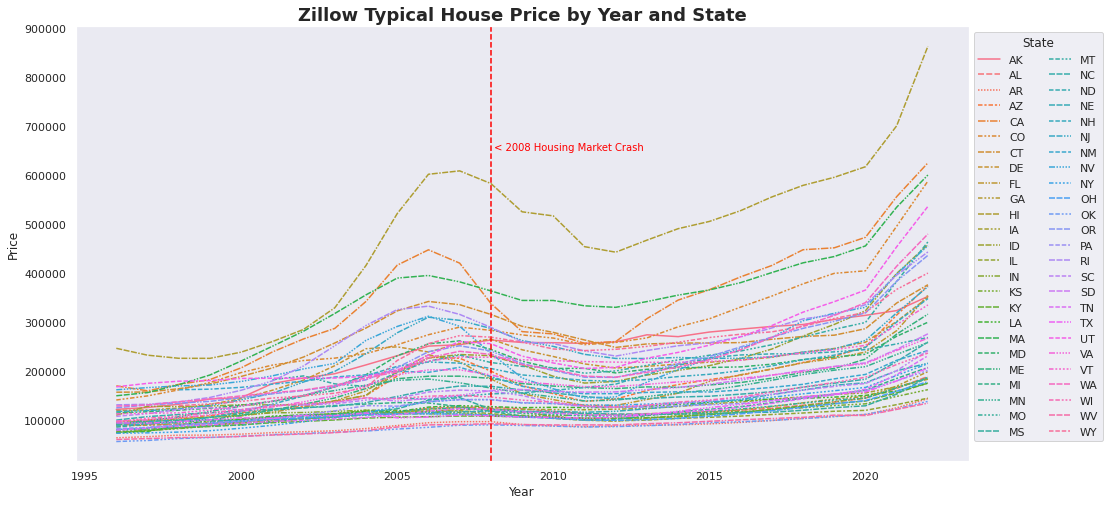

In [199]:
fig, ax = plt.subplots(figsize=(16, 8))
house_price_raw = sns.lineplot(data=housing_prices, ax=ax);
ax.axvline(x=2008, color='red', linestyle='--');
ax.text(2008,650000,' < 2008 Housing Market Crash', color='red');
ax.legend(title='State', bbox_to_anchor = (1,1), ncol=2);
ax.set_title('Zillow Typical House Price by Year and State', fontweight='bold', fontsize=18);
ax.set_ylabel('Price', fontsize=12);
ax.set_xlabel('Year', fontsize=12);

>In general, we can see that there has been a rise in typical housing prices across all states since 1996. From 2004 to 2006, there was a steep rise in prices before they drop at 2008 (marked down as the Housing Crash). After this infamous crash, prices began to increase again, and around 2020 we can see that there is a steep increase once again.

>Though this data tells us some interesting information, it is overwhelming to look at. Let's consolidate this data into a more digestible format by grouping this state data into region--

In [200]:
# since 2022 isn't quite over and our US Census data doesn't report it, let's stop at 2021
housing_prices = housing_prices[:-1]

# list of state abbr by regiom
west = ['WA','OR','CA','ID','NV','MT','WY','UT','AZ','CO','NM']
midwest = ['ND','MN','WI','MI','SD','NE','KS','IA','MO','IL','IN','OH']
south = ['TX','OK','AR','LA','MS','TN','KY','AL','GA','FL','SC','NC','VA','WV','MD','DE']
northeast = ['PA','NJ','NY','CT','MA','RI','VT','NH','ME', 'DC']

# create an empty list for our region indexes
region_idx = []

# loop threw each column (state) and append its corresponding region
for s in housing_prices.columns:
    if s in west:
        region_idx.append('west')
    elif s in midwest:
        region_idx.append('midwest')
    elif s in south:
        region_idx.append('south')
    elif s in northeast:
        region_idx.append('northeast')
    else:
        region_idx.append('other')

# adding an additional index REGION to our DF
housing_prices.columns = [housing_prices.columns, region_idx]
housing_prices.columns = housing_prices.columns.rename('Region',level=1)

# create new DF based off of region
region_prices = housing_prices.groupby(level=1, axis=1).mean().copy()

In [201]:
housing_prices.head()

StateName,AK,AL,AR,AZ,CA,CO,CT,DE,FL,GA,HI,IA,ID,IL,IN,KS,KY,LA,MA,MD,ME,MI,MN,MO,MS,MT,NC,ND,NE,NH,NJ,NM,NV,NY,OH,OK,OR,PA,RI,SC,SD,TN,TX,UT,VA,VT,WA,WI,WV,WY
Region,other,south,south,west,west,west,northeast,south,south,south,other,midwest,west,midwest,midwest,midwest,south,south,northeast,south,northeast,midwest,midwest,midwest,south,west,south,midwest,midwest,northeast,northeast,west,west,northeast,midwest,south,west,northeast,northeast,south,midwest,south,south,west,south,northeast,west,midwest,south,west
Year,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1996,122851.082483,91635.085441,64842.133202,97884.914192,170710.305593,141931.695121,157795.835918,120397.807427,96015.947614,76066.055245,247274.320347,88762.306503,110872.975373,81306.790905,91433.455072,77004.571508,75927.259013,75177.824115,150544.168480,115404.433409,93434.331562,86552.792943,95227.381026,80416.224991,NaN,NaN,100965.048854,NaN,93012.006424,89631.506084,118492.611036,NaN,162738.250345,74184.462641,81681.477236,57268.788082,125999.790689,83597.244394,132043.045550,108642.456654,NaN,80381.057773,95283.401169,168791.014859,98856.823506,113682.052898,129488.184812,97608.507342,61442.903865,NaN
1997,126638.193476,91469.002998,67194.061954,101379.454031,160675.988546,150275.340713,158227.036356,121606.737042,98815.579103,80054.145780,233280.429052,90772.676859,129129.023869,82813.503528,98996.751439,79666.697759,79267.803550,77721.413885,156972.933010,118069.603688,95443.869962,93486.630236,99936.656258,82682.036027,NaN,NaN,108053.145697,NaN,97528.710396,93055.813211,120371.704050,NaN,167111.637655,74959.297866,85376.109422,59415.545126,131796.573949,86300.915861,133167.101770,113980.292529,NaN,84430.406372,94690.945273,175850.317331,101399.269340,114913.699825,131726.135946,104823.877051,63277.469229,NaN
1998,133300.929001,92771.422375,70293.157486,105334.663816,173756.573994,162551.283449,164879.485937,125389.490635,103705.466988,84978.281148,226922.494232,92154.964152,128468.758903,85875.549991,101068.965212,83579.941213,84940.253243,90868.527774,173055.137991,121142.836884,95430.022426,100425.491924,107586.045449,86599.403092,NaN,NaN,112305.312451,NaN,101519.230316,97513.813250,123701.898983,162790.839639,170603.967761,76547.698719,89853.791288,63364.950392,135372.692610,92049.463701,137984.150878,122407.980573,NaN,88795.863771,97760.951006,180216.907843,105672.968194,115700.951465,138282.841171,109368.011982,65344.723183,130329.747523
1999,144150.084175,93757.628787,70291.257227,110135.420553,183552.930715,177611.561687,174553.168414,132766.425729,106935.189550,89668.752565,226820.252744,97309.508045,129542.291772,90314.194338,107324.707612,88969.910386,87849.050975,99797.189348,192902.151757,125212.973935,101706.614690,106347.837320,118557.102725,89524.065607,96714.383542,NaN,115806.763834,NaN,101613.675867,106157.674602,130534.368260,163967.400692,172409.528935,79306.753228,93973.721025,65523.788405,139173.032239,95490.672502,147088.983654,126547.164080,NaN,91311.365860,101439.207706,181481.741749,111793.143482,121297.911190,143928.787331,116265.740544,65823.610307,134035.510222
2000,146534.783153,97781.446436,72368.006901,115962.153458,207417.708620,197890.444794,189923.963738,144697.460503,109444.006880,94659.257670,239433.658142,102061.943377,132233.837123,95634.773508,111718.297147,97711.337002,91446.960945,103004.036835,221369.982312,131368.785970,110536.900190,114407.025910,129458.909578,90611.654488,100344.291464,NaN,119492.514590,NaN,99546.672006,118007.994414,142262.536256,167712.885203,179721.126320,84417.650867,98291.704199,68018.953284,146738.391234,99022.341698,161750.341852,121956.136053,NaN,94640.020184,105523.905508,185868.722499,119237.568950,129658.874870,150220.778826,122306.940647,67546.723142,139016.854483


> We now have a hierarchical columns for our **housing_prices** dataframe-- both StateName and Region.

In [202]:
region_prices.head()

Region,midwest,northeast,other,south,west
Year,,,,,
1996,87300.551395,112600.584285,185062.701415,87887.135025,138552.141373
1997,91608.364898,114823.596879,179959.311264,90629.694771,143493.059005
1998,95803.139462,119651.402594,180111.711616,95316.145740,148770.827671
1999,101020.046347,127670.922033,185485.168460,98827.368458,153583.820590
2000,106174.925786,139661.176244,192984.220648,102595.629707,162278.290256


> We also have an additional dataframe **region_prices** that contain the same data, but grouped only by region.<br>
Now that we have this smaller dataframe, let's see what that line plot looks like--

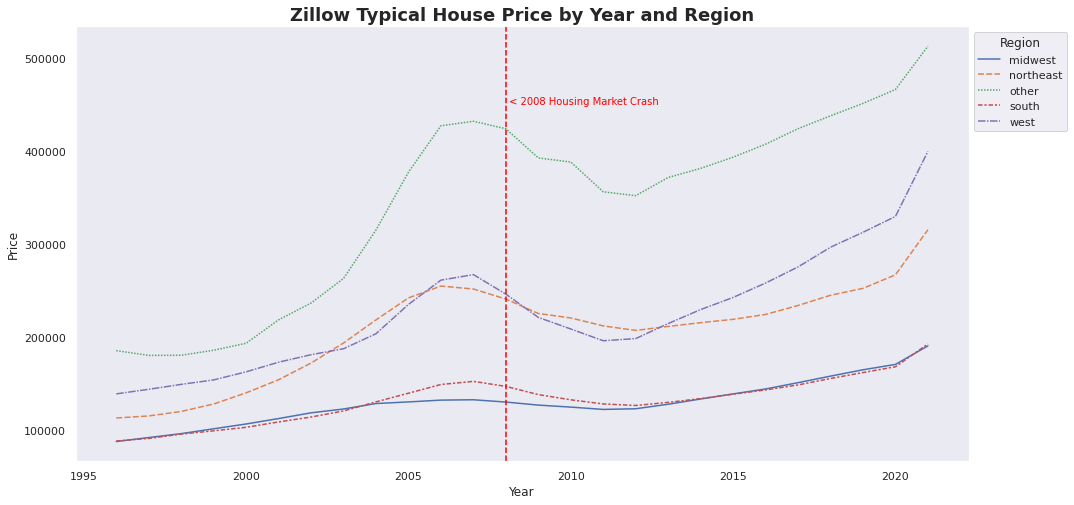

In [203]:
fig2, ax2 = plt.subplots(figsize=(16, 8))
region_price_line = sns.lineplot(data=region_prices, ax=ax2);
ax2.axvline(x=2008, color='red', linestyle='--');
ax2.text(2008,450000,' < 2008 Housing Market Crash', color='red');
ax2.legend(title='Region', bbox_to_anchor = (1,1));
ax2.set_title('Zillow Typical House Price by Year and Region', fontweight='bold', fontsize=18);
ax2.set_ylabel('Price', fontsize=12);
ax2.set_xlabel('Year', fontsize=12);

>This line plot is a lot more digestible! We can still see that the housing price trend is generally increasing, and around 2008 we had a decline. 
The only downfall of this grouping is that we lose the granularity of typical price home we were getting with the state data. For now, this is okay for what we want to look into. Let's take a look at some general statistics for typical house price by region--

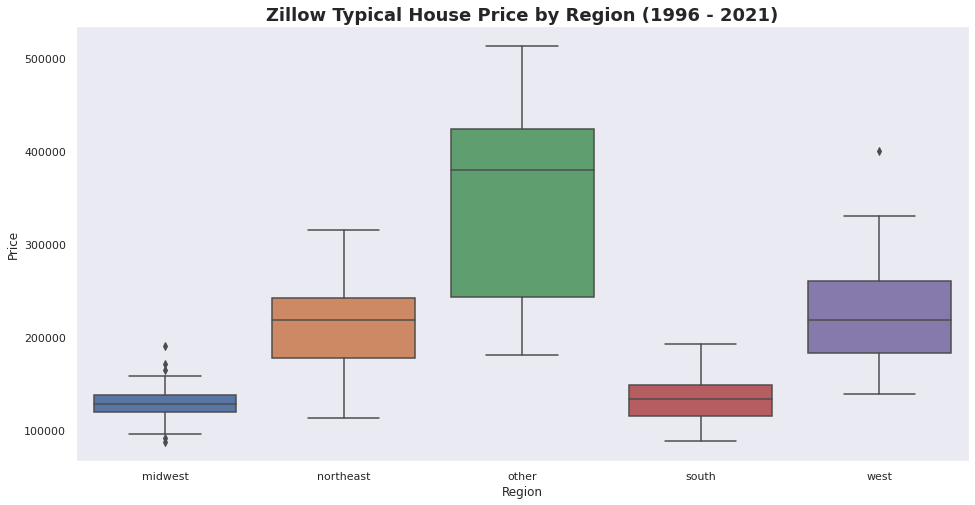

In [204]:
fig3, ax3 = plt.subplots(figsize=(16,8))
house_price_boxplot = sns.boxplot(data=region_prices, ax=ax3)
ax3.set_title("Zillow Typical House Price by Region (1996 - 2021)", fontweight='bold', fontsize=18);
ax3.set_ylabel("Price", fontsize=12);
ax3.set_xlabel("Region", fontsize=12);

> From this box-and-whisker plot, we can see that housing prices in the other region (AK and HI) has the largest price range and highest median price for the typical home. The midwest and south regions have a much tighter price range and lower median price for the typical home. The northeast and west regions are comparable in their typical house price range and median house price.<br>
Now that we have cleaned and have an understanding of the Zillow dataset, we can clean our US Census dataset.

### US Census median household income cleaning

>Now let's clean the US Census median household income dataset. First, let's see what the raw data looks like--

In [205]:
household_income.head(10)

,Table with row headers in column A and column headers in rows 8 through 9 and 63 through 64,Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9,Unnamed: 10,Unnamed: 11,Unnamed: 12,Unnamed: 13,Unnamed: 14,Unnamed: 15,Unnamed: 16,Unnamed: 17,Unnamed: 18,Unnamed: 19,Unnamed: 20,Unnamed: 21,Unnamed: 22,Unnamed: 23,Unnamed: 24,...,Unnamed: 56,Unnamed: 57,Unnamed: 58,Unnamed: 59,Unnamed: 60,Unnamed: 61,Unnamed: 62,Unnamed: 63,Unnamed: 64,Unnamed: 65,Unnamed: 66,Unnamed: 67,Unnamed: 68,Unnamed: 69,Unnamed: 70,Unnamed: 71,Unnamed: 72,Unnamed: 73,Unnamed: 74,Unnamed: 75,Unnamed: 76,Unnamed: 77,Unnamed: 78,Unnamed: 79,Unnamed: 80
0,Table H-8. Median Household Income by State: 1...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,"Information on confidentiality protection, sam...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Footnotes are available at <www.census.gov/top...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,"Source: U.S. Census Bureau, Current Population...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,(Households as of March of the following year....,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,Current Dollars,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,State,2021,NaN,2020 (41),NaN,2019,NaN,2018,NaN,2017 (40),NaN,2017,NaN,2016,NaN,2015,NaN,2014,NaN,2013 (39),NaN,2013 (38),NaN,2012,NaN,...,NaN,1995 (25),NaN,1994 (24),NaN,1993 (23),NaN,1992 (22),NaN,1991,NaN,1990,NaN,1989,NaN,1988,NaN,1987 (21),NaN,1986,NaN,1985 (20),NaN,1984 (19),NaN
7,NaN,Median income,Standard error,Median income,Standard error,Median income,Standard error,Median income,Standard error,Median income,Standard error,Median income,Standard error,Median income,Standard error,Median income,Standard error,Median income,Standard error,Median income,Standard error,Median income,Standard error,Median income,Standard error,...,Standard error,Median income,Standard error,Median income,Standard error,Median income,Standard error,Median income,Standard error,Median income,Standard error,Median income,Standard error,Median income,Standard error,Median income,Standard error,Median income,Standard error,Median income,Standard error,Median income,Standard error,Median income,Standard error
8,United States,"70,784",368,"68,010",535,"68,703",550,"63,179",420,"61,136",322,"61,372",335,"59,039",436,"56,516",321,"53,657",392,"53,585",654,"51,939",276,"51,017",209,...,179,"34,076",197,"32,264",147,"31,241",146,"30,636",145,"30,126",144,"29,943",153,"28,906",159,"27,225",139,"26,061",127,"24,897",129,"23,618",128,"22,415",102
9,Alabama,"56,929","2,294","54,689","2,563","56,200","2,512","49,936","2,423","50,865","1,094","51,113",845,"47,221","2,301","44,509","3,419","42,278","1,529","47,320","5,511","41,381","2,315","43,464","2,529",...,"1,258","25,991","1,266","27,196","1,559","25,082","1,088","25,808","1,058","24,346","1,068","23,357","1,037","21,284","1,070","19,948",912,"19,734","1,147","19,132",885,"18,333",760,"17,310",605


In [206]:
household_income.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 115 entries, 0 to 114
Data columns (total 81 columns):
 #   Column                                                                                       Non-Null Count  Dtype 
---  ------                                                                                       --------------  ----- 
 0   Table with row headers in column A and column headers in rows 8 through 9 and 63 through 64  113 non-null    object
 1   Unnamed: 1                                                                                   108 non-null    object
 2   Unnamed: 2                                                                                   106 non-null    object
 3   Unnamed: 3                                                                                   108 non-null    object
 4   Unnamed: 4                                                                                   106 non-null    object
 5   Unnamed: 5                                 

> The household median income is messier than our Zillow dataset. For this dataset, we have some header information about the data we are pulling in the first six rows of data. We do not need this header information for analysis, so let's drop those.

In [207]:
# Set column header names
houseIncome_header = household_income.iloc[6]
household_income.columns = houseIncome_header
# Drop columns without data (drop header information)
household_income = household_income.iloc[8:]
household_income.reset_index(inplace=True, drop=True)

household_income.head()

6,State,2021,NaN,2020 (41),NaN,2019,NaN,2018,NaN,2017 (40),NaN,2017,NaN,2016,NaN,2015,NaN,2014,NaN,2013 (39),NaN,2013 (38),NaN,2012,NaN,...,NaN,1995 (25),NaN,1994 (24),NaN,1993 (23),NaN,1992 (22),NaN,1991,NaN,1990,NaN,1989,NaN,1988,NaN,1987 (21),NaN,1986,NaN,1985 (20),NaN,1984 (19),NaN
0,United States,"70,784",368,"68,010",535,"68,703",550,"63,179",420,"61,136",322,"61,372",335,"59,039",436,"56,516",321,"53,657",392,"53,585",654,"51,939",276,"51,017",209,...,179,"34,076",197,"32,264",147,"31,241",146,"30,636",145,"30,126",144,"29,943",153,"28,906",159,"27,225",139,"26,061",127,"24,897",129,"23,618",128,"22,415",102
1,Alabama,"56,929","2,294","54,689","2,563","56,200","2,512","49,936","2,423","50,865","1,094","51,113",845,"47,221","2,301","44,509","3,419","42,278","1,529","47,320","5,511","41,381","2,315","43,464","2,529",...,"1,258","25,991","1,266","27,196","1,559","25,082","1,088","25,808","1,058","24,346","1,068","23,357","1,037","21,284","1,070","19,948",912,"19,734","1,147","19,132",885,"18,333",760,"17,310",605
2,Alaska,"81,133","3,967","74,746","3,557","78,394","6,685","68,734","3,390","77,987","3,718","72,231","2,719","75,723","4,086","75,112","3,485","67,629","3,153","72,472","5,446","61,137","3,301","63,648","2,839",...,"1,907","47,954","2,008","45,367","1,494","42,931","1,643","41,802","1,156","40,612","1,822","39,298","1,627","36,006","1,378","33,103","1,183","33,233","1,497","31,356","1,017","34,782","1,089","32,356","1,473"
3,Arizona,"70,821","3,394","67,088","3,409","70,674","3,391","62,283","2,291","59,700","2,689","61,125","2,642","57,100","1,971","52,248","2,008","49,254","2,304","52,611","4,365","50,602","4,831","47,044","2,922",...,"1,274","30,863","1,360","31,293",773,"30,510","1,120","29,358","1,088","30,737",897,"29,224","1,141","28,552","1,210","26,435",843,"26,749",892,"25,500",718,"23,877",744,"21,425",609
4,Arkansas,"50,784","1,440","50,777","1,837","54,539","2,384","49,781","2,108","49,751","2,491","48,829","2,642","45,907","2,165","42,798","1,572","44,922","2,546","39,376","2,402","39,919","2,389","39,018","2,812",...,978,"25,814",999,"25,565",944,"23,039",847,"23,882","1,398","23,435",783,"22,786",981,"21,433",915,"20,172",706,"18,827","1,008","18,730",765,"17,451",764,"15,674",748


In [208]:
household_income.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 107 entries, 0 to 106
Data columns (total 81 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   State           106 non-null    object
 1   2021            106 non-null    object
 2   nan             105 non-null    object
 3   2020 (41)       106 non-null    object
 4   nan             105 non-null    object
 5   2019            106 non-null    object
 6   nan             105 non-null    object
 7   2018            106 non-null    object
 8   nan             105 non-null    object
 9   2017 (40)       106 non-null    object
 10  nan             105 non-null    object
 11  2017            106 non-null    object
 12  nan             105 non-null    object
 13  2016            106 non-null    object
 14  nan             105 non-null    object
 15  2015            106 non-null    object
 16  nan             105 non-null    object
 17  2014            106 non-null    object
 18  nan       

>We can see that this data has 115 rows and 81 columns. The first column is **State** which is how we want to consolidate this dataset with the Zillow dataset. The rest of the columns are a mix of **year**, **NaN**, and **year(XX)**. The **year** column is the yearly median household income of the corresponding state. The **year(XX)** columns are the *adjusted* yearly median household income of the corresponding state after a specified date listed in the US Census dataset footnotes. The **NaN** columns are the *standard error* dollar amount for the corresponding year. <br>
We do not need these *standard error* (**NaN**) columns for the analysis so let's drop those columns. Let's also drop the first row (the *United States* row), since we want to see our median household income by state.

In [209]:
# Drop the NaN columns (previous known as standard error)
household_income = household_income.loc[:, household_income.columns.notna()]
# Drop United States row
household_income = household_income.iloc[1:]
household_income.reset_index(inplace=True, drop=True)

household_income.head()

6,State,2021,2020 (41),2019,2018,2017 (40),2017,2016,2015,2014,2013 (39),2013 (38),2012,2011,2010 (37),2009 (36),2008,2007,2006,2005,2004 (revised),2003,2002,2001,2000 (30),1999 (29),1998,1997,1996,1995 (25),1994 (24),1993 (23),1992 (22),1991,1990,1989,1988,1987 (21),1986,1985 (20),1984 (19)
0,Alabama,"56,929","54,689","56,200","49,936","50,865","51,113","47,221","44,509","42,278","47,320","41,381","43,464","42,590","40,933","39,980","44,476","42,212","37,952","37,150","36,629","37,255","37,603","35,160","35,424","36,251","36,266","31,939","30,302","25,991","27,196","25,082","25,808","24,346","23,357","21,284","19,948","19,734","19,132","18,333","17,310"
1,Alaska,"81,133","74,746","78,394","68,734","77,987","72,231","75,723","75,112","67,629","72,472","61,137","63,648","57,431","57,848","61,604","63,989","62,993","56,418","55,891","55,063","51,837","52,774","57,363","52,847","51,396","50,692","47,994","52,779","47,954","45,367","42,931","41,802","40,612","39,298","36,006","33,103","33,233","31,356","34,782","32,356"
2,Arizona,"70,821","67,088","70,674","62,283","59,700","61,125","57,100","52,248","49,254","52,611","50,602","47,044","48,621","46,896","45,739","46,914","47,215","46,657","45,245","43,846","41,166","39,734","42,704","39,783","36,995","37,090","32,740","31,637","30,863","31,293","30,510","29,358","30,737","29,224","28,552","26,435","26,749","25,500","23,877","21,425"
3,Arkansas,"50,784","50,777","54,539","49,781","49,751","48,829","45,907","42,798","44,922","39,376","39,919","39,018","41,302","38,587","36,538","39,586","40,795","37,057","36,658","34,984","32,002","32,387","33,339","29,697","29,682","27,665","26,162","27,123","25,814","25,565","23,039","23,882","23,435","22,786","21,433","20,172","18,827","18,730","17,451","15,674"
4,California,"81,575","77,652","78,105","70,489","70,038","69,759","66,637","63,636","60,487","60,794","57,528","57,020","53,367","54,283","56,134","57,014","55,734","55,319","51,755","49,222","49,300","47,437","47,262","46,816","43,629","40,934","39,694","38,812","37,009","35,331","34,073","34,903","33,664","33,290","33,009","30,287","30,146","29,010","26,981","25,287"


> We are getting closer to get this dataset in a similiar format as our Zillow dataframe! Now we will change the state names in the **State** column to the states abbreviation because that's how they are listed in the Zillow dataframe.

In [210]:
# create a dictionary of states and their abbreviations
us_state_to_abbrev = {
    "Alabama": "AL",
    "Alaska": "AK",
    "Arizona": "AZ",
    "Arkansas": "AR",
    "California": "CA",
    "Colorado": "CO",
    "Connecticut": "CT",
    "Delaware": "DE",
    "Florida": "FL",
    "Georgia": "GA",
    "Hawaii": "HI",
    "Idaho": "ID",
    "Illinois": "IL",
    "Indiana": "IN",
    "Iowa": "IA",
    "Kansas": "KS",
    "Kentucky": "KY",
    "Louisiana": "LA",
    "Maine": "ME",
    "Maryland": "MD",
    "Massachusetts": "MA",
    "Michigan": "MI",
    "Minnesota": "MN",
    "Mississippi": "MS",
    "Missouri": "MO",
    "Montana": "MT",
    "Nebraska": "NE",
    "Nevada": "NV",
    "New Hampshire": "NH",
    "New Jersey": "NJ",
    "New Mexico": "NM",
    "New York": "NY",
    "North Carolina": "NC",
    "North Dakota": "ND",
    "Ohio": "OH",
    "Oklahoma": "OK",
    "Oregon": "OR",
    "Pennsylvania": "PA",
    "Rhode Island": "RI",
    "South Carolina": "SC",
    "South Dakota": "SD",
    "Tennessee": "TN",
    "Texas": "TX",
    "Utah": "UT",
    "Vermont": "VT",
    "Virginia": "VA",
    "Washington": "WA",
    "West Virginia": "WV",
    "Wisconsin": "WI",
    "Wyoming": "WY",
    "District of Columbia": "DC",
    "American Samoa": "AS",
    "Guam": "GU",
    "Northern Mariana Islands": "MP",
    "Puerto Rico": "PR",
    "United States Minor Outlying Islands": "UM",
    "U.S. Virgin Islands": "VI",
}

In [211]:
# replace state name to state abbreviation
household_income['State'] = household_income['State'].map(lambda x: us_state_to_abbrev.get(x, x))
household_income.head()

6,State,2021,2020 (41),2019,2018,2017 (40),2017,2016,2015,2014,2013 (39),2013 (38),2012,2011,2010 (37),2009 (36),2008,2007,2006,2005,2004 (revised),2003,2002,2001,2000 (30),1999 (29),1998,1997,1996,1995 (25),1994 (24),1993 (23),1992 (22),1991,1990,1989,1988,1987 (21),1986,1985 (20),1984 (19)
0,AL,"56,929","54,689","56,200","49,936","50,865","51,113","47,221","44,509","42,278","47,320","41,381","43,464","42,590","40,933","39,980","44,476","42,212","37,952","37,150","36,629","37,255","37,603","35,160","35,424","36,251","36,266","31,939","30,302","25,991","27,196","25,082","25,808","24,346","23,357","21,284","19,948","19,734","19,132","18,333","17,310"
1,AK,"81,133","74,746","78,394","68,734","77,987","72,231","75,723","75,112","67,629","72,472","61,137","63,648","57,431","57,848","61,604","63,989","62,993","56,418","55,891","55,063","51,837","52,774","57,363","52,847","51,396","50,692","47,994","52,779","47,954","45,367","42,931","41,802","40,612","39,298","36,006","33,103","33,233","31,356","34,782","32,356"
2,AZ,"70,821","67,088","70,674","62,283","59,700","61,125","57,100","52,248","49,254","52,611","50,602","47,044","48,621","46,896","45,739","46,914","47,215","46,657","45,245","43,846","41,166","39,734","42,704","39,783","36,995","37,090","32,740","31,637","30,863","31,293","30,510","29,358","30,737","29,224","28,552","26,435","26,749","25,500","23,877","21,425"
3,AR,"50,784","50,777","54,539","49,781","49,751","48,829","45,907","42,798","44,922","39,376","39,919","39,018","41,302","38,587","36,538","39,586","40,795","37,057","36,658","34,984","32,002","32,387","33,339","29,697","29,682","27,665","26,162","27,123","25,814","25,565","23,039","23,882","23,435","22,786","21,433","20,172","18,827","18,730","17,451","15,674"
4,CA,"81,575","77,652","78,105","70,489","70,038","69,759","66,637","63,636","60,487","60,794","57,528","57,020","53,367","54,283","56,134","57,014","55,734","55,319","51,755","49,222","49,300","47,437","47,262","46,816","43,629","40,934","39,694","38,812","37,009","35,331","34,073","34,903","33,664","33,290","33,009","30,287","30,146","29,010","26,981","25,287"


> An additional problem we must address is in the middle of our dataframe--

In [212]:
household_income.loc[50:56]

6,State,2021,2020 (41),2019,2018,2017 (40),2017,2016,2015,2014,2013 (39),2013 (38),2012,2011,2010 (37),2009 (36),2008,2007,2006,2005,2004 (revised),2003,2002,2001,2000 (30),1999 (29),1998,1997,1996,1995 (25),1994 (24),1993 (23),1992 (22),1991,1990,1989,1988,1987 (21),1986,1985 (20),1984 (19)
50,WY,"71,052","65,450","65,134","62,539","59,536","57,837","57,829","60,925","55,690","67,441","55,700","57,512","54,509","52,201","52,470","53,337","48,744","47,041","44,718","45,397","42,555","39,763","39,719","39,629","37,248","35,250","33,423","30,953","31,529","33,140","29,442","30,209","29,050","29,460","29,521","26,419","27,590","23,559","22,081","23,816"
51,2021 Dollars,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
52,State,2021,2020 (41),2019,2018,2017 (40),2017,2016,2015,2014,2013 (39),2013 (38),2012,2011,2010 (37),2009 (36),2008,2007,2006,2005,2004 (revised),2003,2002,2001,2000 (30),1999 (29),1998,1997,1996,1995 (25),1994 (24),1993 (23),1992 (22),1991,1990,1989,1988,1987 (21),1986,1985 (20),1984 (19)
53,NaN,Median income,Median income,Median income,Median income,Median income,Median income,Median income,Median income,Median income,Median income,Median income,Median income,Median income,Median income,Median income,Median income,Median income,Median income,Median income,Median income,Median income,Median income,Median income,Median income,Median income,Median income,Median income,Median income,Median income,Median income,Median income,Median income,Median income,Median income,Median income,Median income,Median income,Median income,Median income,Median income
54,United States,"70,784","71,186","72,808","68,168","67,571","67,832","66,657","64,631","61,468","62,425","60,507","60,313","60,428","61,364","63,011","63,455","65,801","64,930","64,427","63,745","63,967","64,047","64,779","66,248","66,385","64,781","62,484","61,225","60,348","58,515","57,843","58,153","58,607","60,370","61,153","60,115","59,624","58,920","56,871","55,828"
55,AL,"56,929","57,243","59,558","53,879","56,219","56,493","53,314","50,900","48,432","55,126","48,207","51,384","51,417","50,975","50,609","56,105","55,294","51,124","51,666","52,667","55,014","56,789","53,936","55,888","59,134","60,418","53,930","52,272","46,029","49,324","46,440","48,989","47,363","47,092","45,028","44,047","45,148","45,277","44,145","43,113"
56,AK,"81,133","78,236","83,079","74,161","86,196","79,834","85,494","85,898","77,473","84,427","71,222","75,246","69,334","72,039","77,982","80,720","82,515","75,999","77,729","79,172","76,547","79,700","87,996","83,377","83,839","84,451","81,039","91,045","84,925","82,279","79,487","79,348","79,006","79,231","76,174","73,094","76,032","74,205","83,754","80,587"


> The US Census dataset divides their household income into two sections--<br>
The first section (which we have been reading with our .head() function) is the *current dollar amount* for median income, while the second section is the *2021 dollar amount* for median income. The difference between these two sections is the *2021 dollar amount* is adjusted for inflation while the *current dollar amount* is not.<br><br>
Another thing to note is that the data type of all our median income data is currently a string. We need this data to be a float so we can plot it and merge it with our Zillow data.<br><br>
With a quick glance, the two sections are not significantly different and our analysis is intended to be broad, so let's average their data together--

In [213]:
# remove header information in middle of file
household_income = household_income.drop([51,52,53,54])
household_income.reset_index(inplace=True, drop=True)

# set state col as the index
household_income = household_income.set_index('State')

# remove comma in all rows
# convert to float type
household_income = household_income.replace(',','', regex=True)
household_income = household_income.astype(float)

# group data by state
household_income = household_income.groupby(['State']).mean()

household_income.head()

6,2021,2020 (41),2019,2018,2017 (40),2017,2016,2015,2014,2013 (39),2013 (38),2012,2011,2010 (37),2009 (36),2008,2007,2006,2005,2004 (revised),2003,2002,2001,2000 (30),1999 (29),1998,1997,1996,1995 (25),1994 (24),1993 (23),1992 (22),1991,1990,1989,1988,1987 (21),1986,1985 (20),1984 (19)
State,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
AK,81133.0,76491.0,80736.5,71447.5,82091.5,76032.5,80608.5,80505.0,72551.0,78449.5,66179.5,69447.0,63382.5,64943.5,69793.0,72354.5,72754.0,66208.5,66810.0,67117.5,64192.0,66237.0,72679.5,68112.0,67617.5,67571.5,64516.5,71912.0,66439.5,63823.0,61209.0,60575.0,59809.0,59264.5,56090.0,53098.5,54632.5,52780.5,59268.0,56471.5
AL,56929.0,55966.0,57879.0,51907.5,53542.0,53803.0,50267.5,47704.5,45355.0,51223.0,44794.0,47424.0,47003.5,45954.0,45294.5,50290.5,48753.0,44538.0,44408.0,44648.0,46134.5,47196.0,44548.0,45656.0,47692.5,48342.0,42934.5,41287.0,36010.0,38260.0,35761.0,37398.5,35854.5,35224.5,33156.0,31997.5,32441.0,32204.5,31239.0,30211.5
AR,50784.0,51962.5,56169.0,51746.5,52369.5,51399.0,48868.5,45871.0,48191.5,42624.0,43211.5,42573.0,45582.0,43320.0,41395.0,44761.0,47116.5,43487.5,43819.5,42642.5,39629.5,40649.0,42241.0,38275.0,39050.0,36877.0,35168.5,36955.5,35765.0,35965.5,32848.0,34607.5,34512.5,34363.0,33388.0,32356.5,30950.0,31527.5,29736.0,27356.0
AZ,70821.0,68654.0,72785.5,64742.0,62842.0,64342.0,60784.0,55999.5,52839.0,56950.5,54775.5,51330.0,53659.5,52648.0,51819.0,53047.0,54531.5,54753.5,54084.5,53444.5,50977.5,49870.5,54106.5,51274.5,48671.5,49440.5,44011.5,43106.0,42760.5,44023.5,43500.0,42542.5,45266.5,44072.5,44478.0,42403.0,43973.5,42923.5,40686.0,37393.5
CA,81575.0,79465.0,80438.5,73272.0,73724.0,73430.5,70936.0,68205.0,64889.5,65808.5,62273.0,62215.0,58897.5,60941.5,63596.0,64467.5,64370.5,64918.5,61866.0,59997.5,61050.5,59538.5,59881.5,60339.0,57399.0,54564.5,53359.5,52882.0,51275.5,49704.5,48579.5,50578.0,49577.0,50204.0,51421.0,48581.5,49557.5,48832.0,45975.0,44134.0


> Much better! Now we can address the **year(XX)** columns much easier than we could before.<br>
Similiarly the two *dollar amount* sections, we wil just take the mean between the corresponding **year** and **year(XX)** columns since the **year(XX)** columns are a slightly adjusted form of the **year** columns. Because we are performing a general analysis, we will average those two yearly corresponding columns together.<br>
Let's also put this dataframe in a similiar format to our Zillow dataframe.

In [214]:
# clean up extra text at the end of some years
household_income.columns = household_income.columns.str[:4]
# swap year and state axes
household_income = household_income.swapaxes(axis1=0, axis2=1, copy=True)
# set year as the index
household_income.index.name = 'Year'
# need to specify the datatype of index or else it becomes an object
household_income.index = household_income.index.astype(int)
# group data by year
household_income = household_income.groupby(['Year']).mean()

household_income.head()

State,AK,AL,AR,AZ,CA,CO,CT,DC,DE,FL,GA,HI,IA,ID,IL,IN,KS,KY,LA,MA,MD,ME,MI,MN,MO,...,MT,NC,ND,NE,NH,NJ,NM,NV,NY,OH,OK,OR,PA,RI,SC,SD,TN,TX,UT,VA,VT,WA,WI,WV,WY
Year,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1984,56471.5,30211.5,27356.0,37393.5,44134.0,45031.0,52274.0,35618.5,45062.5,34531.0,34878.5,50399.5,34667.5,36812.5,41455.0,39741.0,42985.5,30857.0,33072.0,47052.0,51850.0,36037.5,40081.0,42648.5,36259.0,...,34096.5,35899.5,36252.0,37344.5,45228.0,48478.0,36006.0,44987.5,38444.0,40357.0,36910.0,37348.0,35510.0,37720.0,35445.5,33875.0,29290.0,40184.0,40242.0,46294.5,39406.0,43662.5,36203.0,29396.5,41566.5
1985,59268.0,31239.0,29736.0,40686.0,45975.0,48021.5,52977.0,35913.0,39157.5,36368.0,35867.0,49349.0,35659.5,35376.5,42378.0,38638.0,38830.5,29583.0,36088.5,48064.5,51351.0,34964.0,41308.0,40650.0,37383.5,...,34482.0,36552.0,36133.0,37145.0,44990.5,52789.5,34800.5,39658.5,40280.5,42896.0,36133.0,37307.0,38982.0,41960.5,34141.0,30913.5,30293.5,40457.5,43005.0,48442.5,44303.5,40895.5,39611.0,27235.0,37625.5
1986,52780.5,32204.5,31527.5,42923.5,48832.0,45771.5,55078.5,40940.5,43135.5,38461.0,41021.5,48820.0,37804.5,34926.5,44625.5,38257.5,40274.0,33453.5,35163.5,51069.0,51515.0,39429.0,44783.5,44511.0,36906.0,...,34217.5,36798.0,36204.0,36648.0,51420.5,53385.0,33404.5,44130.5,42124.0,42275.5,35261.0,41699.5,40073.5,44674.0,36978.0,33494.0,30730.0,40671.5,44238.0,50018.5,41407.0,45248.0,44489.0,27713.5,39656.5
1987,54632.5,32441.0,30950.0,43973.5,49557.5,43524.5,54022.5,45134.0,48075.0,40258.0,43915.5,57573.5,36478.5,34119.5,44524.0,37019.5,42056.5,33985.0,35096.0,53001.5,57488.0,38796.5,45540.0,46164.5,38994.0,...,33657.5,37415.5,37113.0,38251.0,53161.0,56289.5,34124.5,44185.5,43373.0,42369.0,35658.5,41160.5,41795.0,46510.0,41178.5,34770.5,34816.5,40639.5,43611.5,49311.0,41780.5,44910.5,43348.5,28287.0,45356.0
1988,53098.5,31997.5,32356.5,42403.0,48581.5,42048.5,58087.0,42893.5,48931.0,40752.0,42613.0,52972.0,38986.0,37614.5,47357.5,42175.0,41009.0,31931.5,32878.0,53275.0,58631.0,42350.0,47274.5,46656.5,37603.5,...,35659.5,39162.5,38644.5,40356.0,55540.0,58206.0,30951.5,44886.0,46381.0,44496.0,37963.0,44509.0,42895.0,47868.0,40956.0,35760.5,33454.0,40041.5,42207.0,52368.5,46498.0,51854.0,47439.5,31043.0,42377.0


***Note: We also changed the datatype of our index column here-- this is so that we can divide our two dataframes later on. This is because two dataframes of different index datatypes cannot be divided (would return a df with all nans)***<br><br>
Now that our data is a formatted how we would like it, let's take a look at the data--

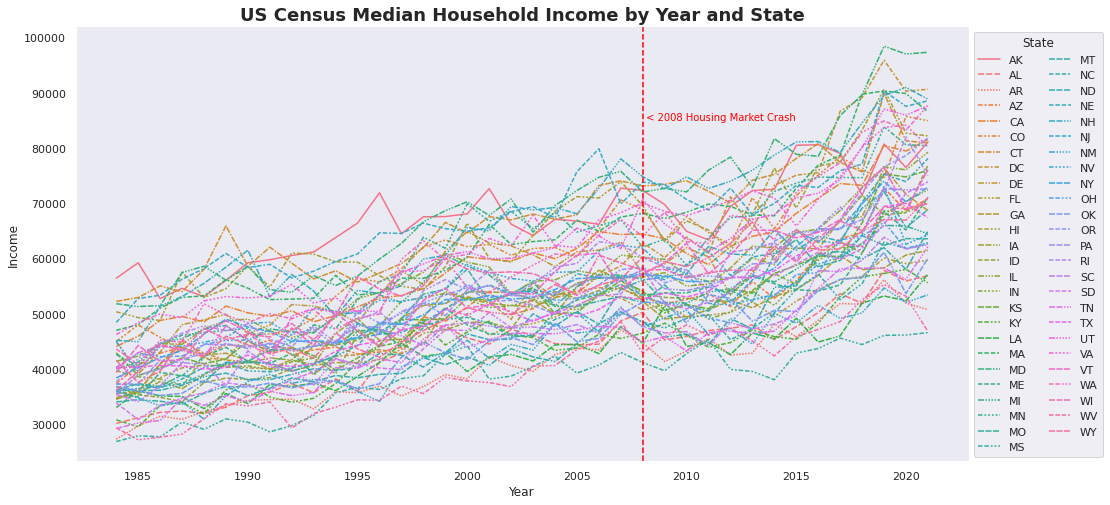

In [215]:
fig4, ax4 = plt.subplots(figsize=(16, 8))
household_income_raw = sns.lineplot(data=household_income, ax=ax4);
ax4.axvline(x=2008, color='red', linestyle='--');
ax4.text(2008,85000,' < 2008 Housing Market Crash', color='red');
ax4.legend(title='State', bbox_to_anchor = (1,1), ncol=2);
ax4.set_title('US Census Median Household Income by Year and State', fontweight='bold', fontsize=18);
ax4.set_ylabel('Income', fontsize=12);
ax4.set_xlabel('Year', fontsize=12);

> Generally, median household income has been increasing since 1984. This graph is busy to look at so it's hard to see any other trends. It also does not completely align with our Zillow data. We need to remove data before 1996 since that's where our Zillow dataset starts. We also need to remove the **DC** state as it is not listed in the Zillow data.<br>
Once we do that, we can do the same type of consolidation to this dataset as we did to the Zillow dataset by grouping our float values by region rather than state.

In [216]:
# drop data before 1996
household_income = household_income[12:]
# remove DC since that isn't in our Zillow data
household_income = household_income.drop(['DC'], axis=1)

household_income.head()

State,AK,AL,AR,AZ,CA,CO,CT,DE,FL,GA,HI,IA,ID,IL,IN,KS,KY,LA,MA,MD,ME,MI,MN,MO,MS,MT,NC,ND,NE,NH,NJ,NM,NV,NY,OH,OK,OR,PA,RI,SC,SD,TN,TX,UT,VA,VT,WA,WI,WV,WY
Year,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1996,71912.0,41287.0,36955.5,43106.0,52882.0,55795.0,57388.0,53559.0,41749.0,44276.5,56915.0,45248.0,47291.5,53893.0,47888.5,44397.5,44163.0,41232.5,53811.0,59941.0,47274.0,53444.5,55851.0,46686.5,36348.0,39082.5,48507.0,42878.5,46344.5,53692.5,64676.0,34180.0,52511.5,48246.5,46421.0,37383.5,48358.5,47550.5,50394.0,47231.5,40229.5,41952.0,45061.0,50465.0,53425.5,44088.5,49971.5,54502.0,34399.5,42174.0
1997,64516.5,42934.5,35168.5,44011.5,53359.5,58116.5,59127.5,57848.0,43628.0,49285.0,55026.0,45413.5,44904.0,55495.5,52277.0,49026.5,44968.5,44710.5,56490.0,62757.0,44054.5,52079.5,57217.5,49137.0,38310.0,39268.5,48178.5,42561.0,46635.5,55112.0,64553.0,40443.5,52230.0,48122.0,48573.5,42144.0,50070.0,50433.0,46776.5,46057.0,39916.5,41183.0,47150.0,57501.0,57745.5,47120.5,59903.0,53226.0,36951.0,44929.5
1998,67571.5,48342.0,36877.0,49440.5,54564.5,62116.0,61994.5,55263.0,46533.0,51540.0,54422.0,49346.0,48894.0,57555.5,52961.0,48935.0,48323.5,42302.5,56445.5,66670.5,47507.5,55747.0,63884.5,53587.5,38816.5,42091.5,47771.5,40395.0,48538.0,59928.5,66417.5,42046.5,52994.0,49845.5,51886.5,44957.5,52075.5,52006.5,54234.0,44344.5,43703.5,45443.0,47698.0,59050.0,57790.0,52482.5,63211.5,55088.5,35596.0,46987.5
1999,67617.5,47692.5,39050.0,48671.5,57399.0,63382.5,66561.0,61344.5,47140.0,51868.0,58550.0,54069.0,47099.0,60952.5,53727.0,49135.5,44386.5,42960.0,57893.5,68682.0,51127.5,60635.5,61884.0,54444.0,42728.5,40834.0,49012.0,42972.0,50817.0,60591.0,65431.0,42855.0,54547.0,52610.0,51952.5,42998.5,53439.0,49675.0,56202.0,47970.0,47136.0,48049.0,50898.5,60584.0,60114.5,54708.5,59825.0,60080.5,38543.5,49004.0
2000,68112.0,45656.0,38275.0,51274.5,60339.0,62174.0,64664.0,64913.0,50079.5,54004.0,66435.0,52831.0,48475.0,59369.5,52669.0,52919.0,46740.0,39591.0,60257.5,70287.5,48030.5,58658.0,69921.5,58123.0,44206.0,42244.5,49385.0,46393.5,53809.5,65636.0,64964.5,45229.5,58975.0,52513.0,55371.5,41800.0,54775.0,54358.5,54385.5,48422.0,47011.0,43944.5,49761.0,61285.0,60786.0,51030.5,54808.5,58111.5,37906.5,51076.0


In [217]:
# create an empty list for our region indexes
region_idx = []

# loop threw each column (state) and append its corresponding region
for s in household_income.columns:
    if s in west:
        region_idx.append('west')
    elif s in midwest:
        region_idx.append('midwest')
    elif s in south:
        region_idx.append('south')
    elif s in northeast:
        region_idx.append('northeast')
    else:
        region_idx.append('other')

# adding an additional index REGION to our DF
household_income.columns = [household_income.columns, region_idx]
household_income.columns = household_income.columns.rename('Region',level=1)

# create new DF based off of region
region_income = household_income.groupby(level=1, axis=1).mean().copy()

In [218]:
household_income.head()

State,AK,AL,AR,AZ,CA,CO,CT,DE,FL,GA,HI,IA,ID,IL,IN,KS,KY,LA,MA,MD,ME,MI,MN,MO,MS,MT,NC,ND,NE,NH,NJ,NM,NV,NY,OH,OK,OR,PA,RI,SC,SD,TN,TX,UT,VA,VT,WA,WI,WV,WY
Region,other,south,south,west,west,west,northeast,south,south,south,other,midwest,west,midwest,midwest,midwest,south,south,northeast,south,northeast,midwest,midwest,midwest,south,west,south,midwest,midwest,northeast,northeast,west,west,northeast,midwest,south,west,northeast,northeast,south,midwest,south,south,west,south,northeast,west,midwest,south,west
Year,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1996,71912.0,41287.0,36955.5,43106.0,52882.0,55795.0,57388.0,53559.0,41749.0,44276.5,56915.0,45248.0,47291.5,53893.0,47888.5,44397.5,44163.0,41232.5,53811.0,59941.0,47274.0,53444.5,55851.0,46686.5,36348.0,39082.5,48507.0,42878.5,46344.5,53692.5,64676.0,34180.0,52511.5,48246.5,46421.0,37383.5,48358.5,47550.5,50394.0,47231.5,40229.5,41952.0,45061.0,50465.0,53425.5,44088.5,49971.5,54502.0,34399.5,42174.0
1997,64516.5,42934.5,35168.5,44011.5,53359.5,58116.5,59127.5,57848.0,43628.0,49285.0,55026.0,45413.5,44904.0,55495.5,52277.0,49026.5,44968.5,44710.5,56490.0,62757.0,44054.5,52079.5,57217.5,49137.0,38310.0,39268.5,48178.5,42561.0,46635.5,55112.0,64553.0,40443.5,52230.0,48122.0,48573.5,42144.0,50070.0,50433.0,46776.5,46057.0,39916.5,41183.0,47150.0,57501.0,57745.5,47120.5,59903.0,53226.0,36951.0,44929.5
1998,67571.5,48342.0,36877.0,49440.5,54564.5,62116.0,61994.5,55263.0,46533.0,51540.0,54422.0,49346.0,48894.0,57555.5,52961.0,48935.0,48323.5,42302.5,56445.5,66670.5,47507.5,55747.0,63884.5,53587.5,38816.5,42091.5,47771.5,40395.0,48538.0,59928.5,66417.5,42046.5,52994.0,49845.5,51886.5,44957.5,52075.5,52006.5,54234.0,44344.5,43703.5,45443.0,47698.0,59050.0,57790.0,52482.5,63211.5,55088.5,35596.0,46987.5
1999,67617.5,47692.5,39050.0,48671.5,57399.0,63382.5,66561.0,61344.5,47140.0,51868.0,58550.0,54069.0,47099.0,60952.5,53727.0,49135.5,44386.5,42960.0,57893.5,68682.0,51127.5,60635.5,61884.0,54444.0,42728.5,40834.0,49012.0,42972.0,50817.0,60591.0,65431.0,42855.0,54547.0,52610.0,51952.5,42998.5,53439.0,49675.0,56202.0,47970.0,47136.0,48049.0,50898.5,60584.0,60114.5,54708.5,59825.0,60080.5,38543.5,49004.0
2000,68112.0,45656.0,38275.0,51274.5,60339.0,62174.0,64664.0,64913.0,50079.5,54004.0,66435.0,52831.0,48475.0,59369.5,52669.0,52919.0,46740.0,39591.0,60257.5,70287.5,48030.5,58658.0,69921.5,58123.0,44206.0,42244.5,49385.0,46393.5,53809.5,65636.0,64964.5,45229.5,58975.0,52513.0,55371.5,41800.0,54775.0,54358.5,54385.5,48422.0,47011.0,43944.5,49761.0,61285.0,60786.0,51030.5,54808.5,58111.5,37906.5,51076.0


> We now have hierarchical columns for our **household_income** dataframe-- both State and Region.

In [219]:
region_income.head()

Region,midwest,northeast,other,south,west
Year,,,,,
1996,48148.708333,51902.333333,64413.50,44216.96875,46892.500000
1997,49296.583333,52421.000000,59771.25,46188.68750,49521.545455
1998,51802.333333,55651.333333,60996.75,47391.78125,52133.772727
1999,53983.791667,57199.944444,63083.75,48964.87500,52512.727273
2000,55432.333333,57315.555556,67273.50,49109.81250,53696.000000


>We also have an additional dataframe **region_income** that contain the same data, but grouped only by region.<br>
Now that we have this smaller dataframe, let's see if we get a better understanding of the data--

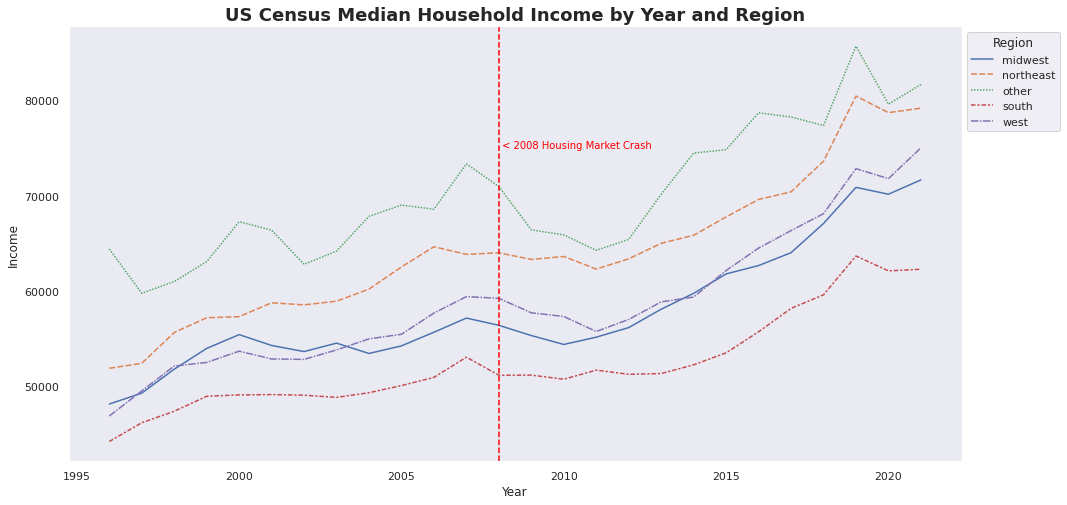

In [220]:
fig5, ax5 = plt.subplots(figsize=(16, 8))
region_income_line = sns.lineplot(data=region_income, ax=ax5);
ax5.axvline(x=2008, color='red', linestyle='--');
ax5.text(2008,75000,' < 2008 Housing Market Crash', color='red');
ax5.legend(title='Region',bbox_to_anchor = (1,1));
ax5.set_title('US Census Median Household Income by Year and Region', fontweight='bold', fontsize=18);
ax5.set_ylabel('Income', fontsize=12);
ax5.set_xlabel('Year', fontsize=12);

> This line plot is much easier to see the trends in median income! We can see that there was a slight increase in median household income right after 2005, and then a decrease around 2008. We can also see that median income started increasing again after 2012, and in all region had a steep increase from 2017 to 2019 before falling off again.<br>
We do lose the granularity of the median household income by state, but this is okay for our general analysis purposes. Now let's take a look at some general statistics for median household income by region--

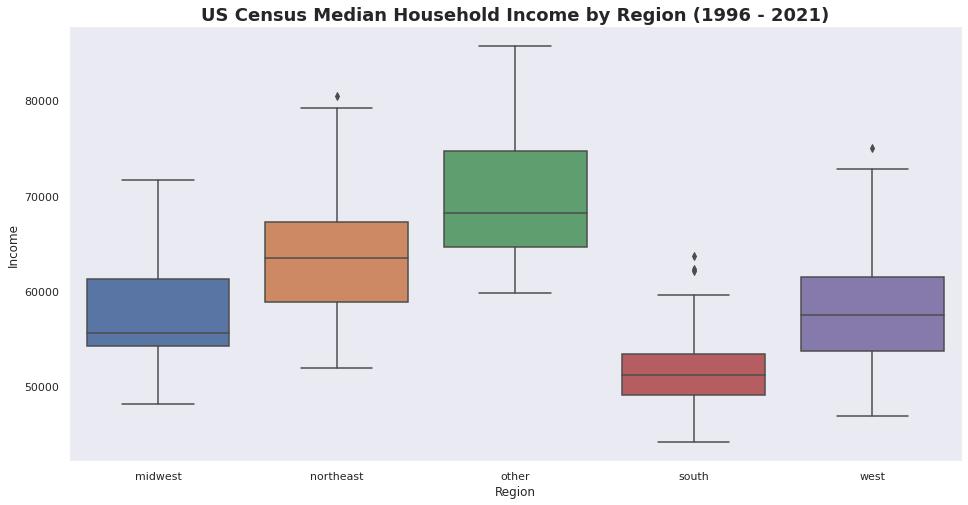

In [221]:
fig6, ax6 = plt.subplots(figsize=(16,8))
household_income_boxplot = sns.boxplot(data=region_income, ax=ax6);
ax6.set_title("US Census Median Household Income by Region (1996 - 2021)", fontweight='bold', fontsize=18);
ax6.set_ylabel("Income", fontsize=12);
ax6.set_xlabel("Region", fontsize=12);

> From this box-and-whisker plot, we can see that median household income in the other region (AK and HI) has the highest income, followed by the northest. It's interesting to see that the west region has such a large median household income range that is somewhat comparable to the midwest region. The south region has a tighter median household income range and the lowest median income value.<br>
Now that our US Census data is cleaned and we have an idea of what our data looks like, we can start merging this dataset with our Zillow dataset, and see if there's any interesting trends we can find.

## Data Analysis
### Home price and Median income cleaning and consolidation

> Before we merge the two datasets, let's take a look at the two line plots side-by-side and see how they compare--

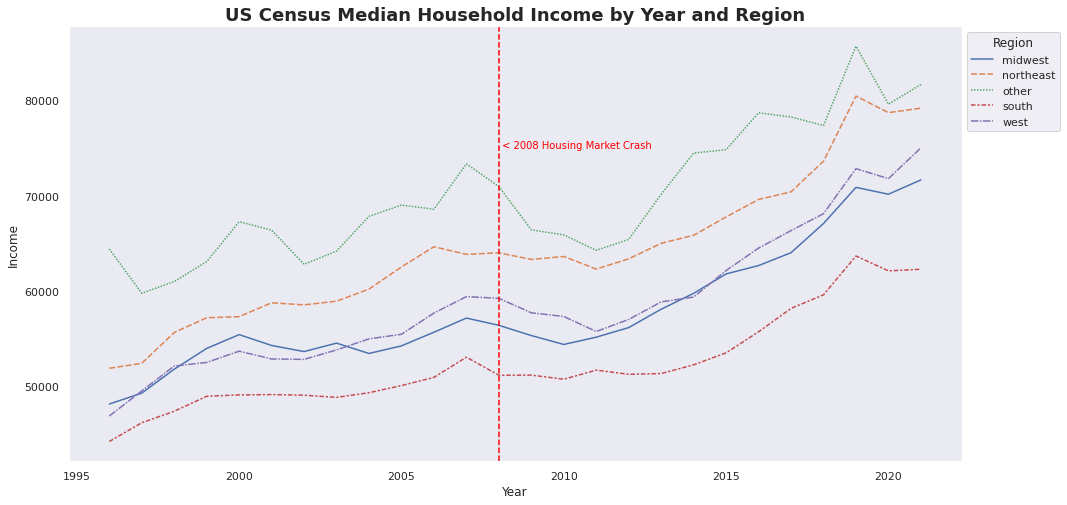

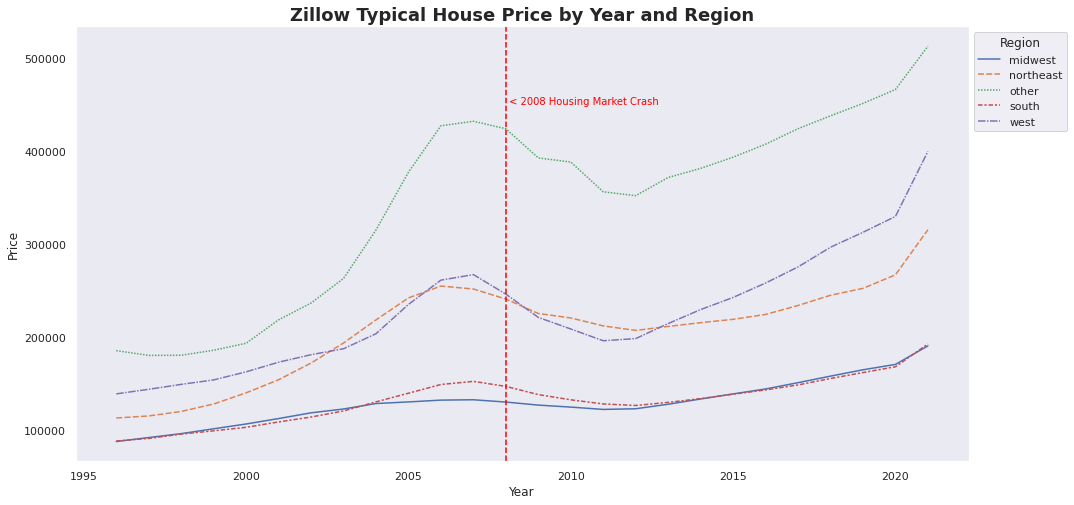

In [222]:
region_income_line.get_figure()
region_price_line.get_figure()

> Interesting! Both plots seem to rise and fall around the same time frame, regardless of region. Let's dig deeper and break down our analysis into region--
>- **Other**: the other region has the highest median household income and have the highest typical house price for all years
>- **Northeast**: the northeast region has the 2nd highest median household income, but have been on par with and in recent years paying less for their houses than the west region
>- **West**: the west region, despite being approximately on par with the midwest region for median household income, are paying more than the northeast and midwest regions for their houses
>- **Midwest**: the midwest region seems to be doing very well, as they a close 3rd for the median household income, but are close to paying the least for their houses
>- **South**: the south region clearly has the lowest median household income by year, and are paying approximately the same amount for their houses as the midwest region

> Let's validate our findings above, with a statistical break down of each dataframe--

In [223]:
#housing_prices.describe()
region_prices.describe()

Region,midwest,northeast,other,south,west
count,26.000000,26.000000,26.000000,26.000000,26.000000
mean,129133.996554,207083.471288,344083.647517,131780.778151,226059.598508
std,24045.490548,51861.613448,103279.682877,25115.754527,62938.385539
min,87300.551395,112600.584285,179959.311264,87887.135025,138552.141373
25%,119097.497615,177113.580051,242887.798701,115280.894560,182290.933548
50%,127794.271735,218434.341940,379054.705291,132827.814858,217511.577433
75%,137158.897196,241466.778656,423733.825592,147783.199661,260109.634333
max,190182.370701,315134.429636,512501.394186,192242.043449,399378.424150


In [224]:
#household_income.describe()
region_income.describe()

Region,midwest,northeast,other,south,west
count,26.000000,26.000000,26.000000,26.000000,26.000000
mean,57897.001603,64202.788462,70054.317308,52353.795673,58767.803322
std,6360.754080,7603.230478,6898.234185,5022.101908,7193.174473
min,48148.708333,51902.333333,59771.250000,44216.968750,46892.500000
25%,54261.500000,58809.708333,64664.625000,49118.656250,53729.147727
50%,55558.395833,63506.388889,68211.000000,51176.953125,57512.386364
75%,61290.562500,67296.152778,74738.875000,53405.890625,61470.011364
max,71657.500000,80452.388889,85686.000000,63680.750000,75024.909091


> What we have gathered from our line plots, align with the general statistics of each dataframe. Now that we have an idea of how to two dataframes compare, we can merge them into one.<br>
Before we merge the two dataframes, let's make sure their dimensions align--

In [225]:
housing_prices.info(verbose=False)
household_income.info(verbose=False)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 26 entries, 1996 to 2021
Columns: 50 entries, ('AK', 'other') to ('WY', 'west')
dtypes: float64(50)
memory usage: 10.4 KB
<class 'pandas.core.frame.DataFrame'>
Int64Index: 26 entries, 1996 to 2021
Columns: 50 entries, ('AK', 'other') to ('WY', 'west')
dtypes: float64(50)
memory usage: 10.4 KB


> Looks good! Both dataframes have 50 rows (one row for each state) and 26 columns (one for each year from 1996 to 2021).<br><br>
For this analysis we decided to divide median household income by typical housing prices. We decided to do this so we can understand each state's debt-to-income ratio. According to multiple banking and investment sites, the ideal debt-to-income ratio for a mortgage should be ideally no higher than 36% (this should ideally include all other debt). This will be our conservative theshold value to see whether or not housing prices are reasonable in a given state. (Please note, this is a general analysis, there are many other variables that are not considered here!)

In [226]:
# get debt-to-income ratio dataframe
income_over_prices = household_income.divide(housing_prices, axis=0)
income_over_prices.head()

State,AK,AL,AR,AZ,CA,CO,CT,DE,FL,GA,HI,IA,ID,IL,IN,KS,KY,LA,MA,MD,ME,MI,MN,MO,MS,MT,NC,ND,NE,NH,NJ,NM,NV,NY,OH,OK,OR,PA,RI,SC,SD,TN,TX,UT,VA,VT,WA,WI,WV,WY
Region,other,south,south,west,west,west,northeast,south,south,south,other,midwest,west,midwest,midwest,midwest,south,south,northeast,south,northeast,midwest,midwest,midwest,south,west,south,midwest,midwest,northeast,northeast,west,west,northeast,midwest,south,west,northeast,northeast,south,midwest,south,south,west,south,northeast,west,midwest,south,west
Year,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1996,0.585359,0.450559,0.569930,0.440374,0.309776,0.393112,0.363685,0.444850,0.434813,0.582080,0.230169,0.509766,0.426538,0.662835,0.523752,0.576557,0.581649,0.548466,0.357443,0.519399,0.505960,0.617479,0.586501,0.580561,NaN,NaN,0.480434,NaN,0.498264,0.599036,0.545823,NaN,0.322675,0.650359,0.568317,0.652773,0.383798,0.568805,0.381648,0.434743,NaN,0.521914,0.472916,0.298979,0.540433,0.387823,0.385916,0.558373,0.559861,NaN
1997,0.509455,0.469389,0.523387,0.434126,0.332094,0.386733,0.373688,0.475697,0.441509,0.615646,0.235879,0.500299,0.347745,0.670126,0.528068,0.615395,0.567298,0.575266,0.359871,0.531525,0.461575,0.557080,0.572538,0.594289,NaN,NaN,0.445878,NaN,0.478172,0.592247,0.536281,NaN,0.312546,0.641975,0.568936,0.709309,0.379904,0.584385,0.351262,0.404079,NaN,0.487775,0.497936,0.326988,0.569486,0.410051,0.454754,0.507766,0.583952,NaN
1998,0.506909,0.521087,0.524617,0.469366,0.314028,0.382132,0.375999,0.440731,0.448703,0.606508,0.239826,0.535468,0.380591,0.670220,0.524009,0.585487,0.568912,0.465535,0.326171,0.550346,0.497826,0.555108,0.593799,0.618798,NaN,NaN,0.425372,NaN,0.478116,0.614564,0.536916,0.258285,0.310626,0.651169,0.577455,0.709501,0.384682,0.564984,0.393045,0.362268,NaN,0.511769,0.487904,0.327661,0.546876,0.453605,0.457117,0.503698,0.544742,0.360528
1999,0.469077,0.508679,0.555546,0.441924,0.312711,0.356860,0.381322,0.462048,0.440828,0.578440,0.258134,0.555639,0.363580,0.674894,0.500602,0.552271,0.505259,0.430473,0.300118,0.548521,0.502696,0.570162,0.521976,0.608149,0.441801,NaN,0.423222,NaN,0.500100,0.570764,0.501255,0.261363,0.316380,0.663374,0.552841,0.656227,0.383975,0.520208,0.382095,0.379068,NaN,0.526211,0.501764,0.333830,0.537730,0.451026,0.415657,0.516752,0.585557,0.365605
2000,0.464818,0.466919,0.528894,0.442166,0.290906,0.314184,0.340473,0.448612,0.457581,0.570509,0.277467,0.517637,0.366585,0.620794,0.471445,0.541585,0.511116,0.384364,0.272203,0.535040,0.434520,0.512713,0.540106,0.641452,0.440543,NaN,0.413289,NaN,0.540545,0.556200,0.456652,0.269684,0.328147,0.622062,0.563338,0.614535,0.373283,0.548952,0.336231,0.397044,NaN,0.464333,0.471561,0.329722,0.509789,0.393575,0.364853,0.475128,0.561189,0.367409


> Now that we have our new **income_over_prices** dataframe. Let's take a look at some of the statistics for it. <br>
Since we have 50 states worth of data and 26 years to look at, let's once again group this data by region and plot a box-and-whisker plot to make it more digestible. 

In [227]:
income_over_prices_region = income_over_prices.T.groupby(['Region']).mean().T.copy()
income_over_prices_region

Region,midwest,northeast,other,south,west
Year,,,,,
1996,0.568241,0.484509,0.407764,0.519655,0.370146
1997,0.559267,0.479037,0.372667,0.526542,0.371861
1998,0.564216,0.490475,0.373368,0.514325,0.364502
1999,0.555339,0.474762,0.363605,0.505086,0.355189
2000,0.542474,0.440096,0.371143,0.485957,0.344694
2001,0.500140,0.410082,0.322259,0.464801,0.315108
2002,0.464638,0.370328,0.281168,0.444446,0.301679
2003,0.454574,0.334401,0.261491,0.423780,0.297097
2004,0.425940,0.305939,0.239565,0.403672,0.283205


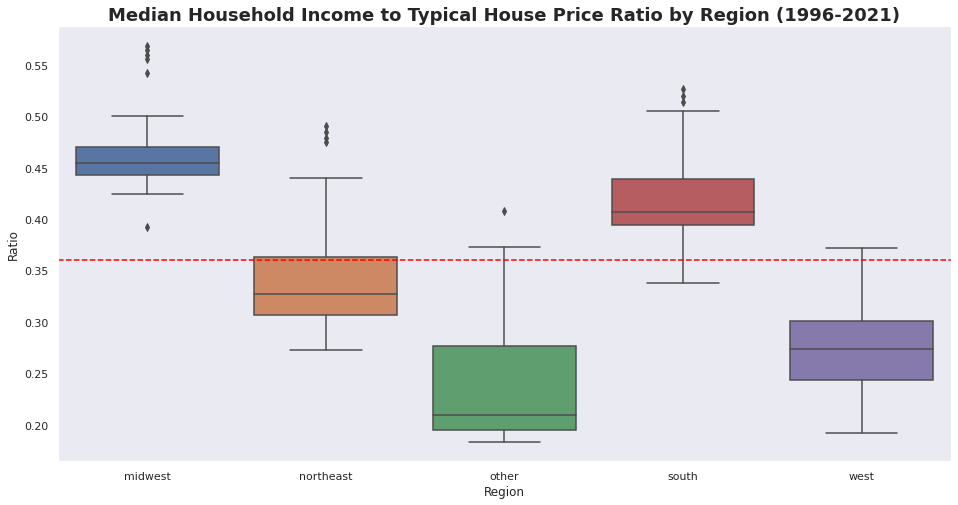

In [228]:
fig7, ax7 = plt.subplots(figsize=(16,8))
iop_regioned_boxplot = sns.boxplot(data=income_over_prices_region, ax=ax7);
ax7.axhline(y=0.36, color='red', linestyle='--');
ax7.set_title("Median Household Income to Typical House Price Ratio by Region (1996-2021)", fontweight='bold', fontsize=18);
ax7.set_ylabel("Ratio", fontsize=12);
ax7.set_xlabel("Region", fontsize=12);

> It doesn't look like all people can fall under that debt-to-income ratio of 36%! The the midwest region (even with outliers) is above that "maximum" 36% ratio. The south also is struggling to fall below the line, though a portion of its lower interquartile range whisker does dip below the line. The northeast region barely makes it under the threshold with their upper quartile range, and both the other and west regions do a fairly good job at staying within ratio guidelines.<br><br>
This box-and-whisker plot is okay, but again we are losing the granularity of state and year! We want to get a general understanding of how our housing market compares to the housing market right before the 2008 housing market crash, so we cannot muddle out any variables that we have!

### Debt-to-Income Plotting by Specified Years

The easiest way to see how our debt-to-income compares by states given a year is through a geographic information system (GIS) plot. To do this, we must import the geometry polygons of each state in the US.<br>
We have a geopandas dataframe, however the dataframe lists the state by its full name rather than abbrevation like our **income_over_prices** dataframe. We must first add the state's abbrevation to the dataframe before we can merge it so it has a shared key.

In [229]:
# mapping state abbrevation to state name
states['State'] = states['name'].map(lambda x: us_state_to_abbrev.get(x, x))
states.head()

,id,name,density,geometry,State
0,01,Alabama,94.650,"POLYGON ((-87.35930 35.00118, -85.60667 34.984...",AL
1,02,Alaska,1.264,"MULTIPOLYGON (((-131.60202 55.11798, -131.5691...",AK
2,04,Arizona,57.050,"POLYGON ((-109.04250 37.00026, -109.04798 31.3...",AZ
3,05,Arkansas,56.430,"POLYGON ((-94.47384 36.50186, -90.15254 36.496...",AR
4,06,California,241.700,"POLYGON ((-123.23326 42.00619, -122.37885 42.0...",CA


> Now that we have a key to merge on, we will take a copy of the **income_over_prices** dataframe and rename it **iop**. We want a copy of the dataframe, since we will be turning it into a GeoDataFrame, and we might want to return to the original dataframe for further analysis. We also need to transpose this new dataframe and remove the **State** and **Region** as indexes as we will want to merge on the state column.   

In [230]:
# take a transposed copy of the income_over_prices df
iop = income_over_prices.T.copy()
# remove indexes and turn into regular ole columns
iop = iop.reset_index(level=['State', 'Region'])
iop.head()

Year,State,Region,1996,1997,1998,1999,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021
0,AK,other,0.585359,0.509455,0.506909,0.469077,0.464818,0.414170,0.354585,0.328420,0.314403,0.287769,0.262986,0.285701,0.273877,0.269288,0.251058,0.246359,0.266769,0.263146,0.267674,0.287089,0.281458,0.270951,0.241528,0.263732,0.243228,0.250295
1,AL,south,0.450559,0.469389,0.521087,0.508679,0.466919,0.435143,0.448208,0.424399,0.395160,0.382894,0.356030,0.383388,0.396640,0.365144,0.387980,0.410801,0.422573,0.420735,0.391566,0.402804,0.415076,0.429562,0.395364,0.420012,0.383462,0.343890
2,AR,south,0.569930,0.523387,0.524617,0.555546,0.528894,0.560615,0.526288,0.500116,0.509385,0.487496,0.454950,0.482026,0.457436,0.450542,0.485167,0.520374,0.479619,0.473929,0.527953,0.491867,0.507775,0.518189,0.495846,0.517179,0.462482,0.402920
3,AZ,west,0.440374,0.434126,0.469366,0.441924,0.442166,0.442057,0.385466,0.366634,0.353899,0.283596,0.239089,0.240195,0.264268,0.302924,0.340112,0.385960,0.356727,0.346335,0.304860,0.305181,0.316060,0.310398,0.296459,0.315420,0.274692,0.224769
4,CA,west,0.309776,0.332094,0.314028,0.312711,0.290906,0.249736,0.223483,0.212110,0.174978,0.148447,0.144902,0.152944,0.190314,0.226079,0.220336,0.228678,0.238381,0.208099,0.187749,0.185995,0.180553,0.176842,0.163492,0.177923,0.167826,0.146600


>Perfect! Now our dataframe is ready to be merged with **states** dataframe. We will use the **State** column to merge.

In [231]:
# merge the two dfs so the iop df has the geometry column for each state
iop = states.merge(iop, on='State', how='left')
iop.head()

,id,name,density,geometry,State,Region,1996,1997,1998,1999,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021
0,01,Alabama,94.650,"POLYGON ((-87.35930 35.00118, -85.60667 34.984...",AL,south,0.450559,0.469389,0.521087,0.508679,0.466919,0.435143,0.448208,0.424399,0.395160,0.382894,0.356030,0.383388,0.396640,0.365144,0.387980,0.410801,0.422573,0.420735,0.391566,0.402804,0.415076,0.429562,0.395364,0.420012,0.383462,0.343890
1,02,Alaska,1.264,"MULTIPOLYGON (((-131.60202 55.11798, -131.5691...",AK,other,0.585359,0.509455,0.506909,0.469077,0.464818,0.414170,0.354585,0.328420,0.314403,0.287769,0.262986,0.285701,0.273877,0.269288,0.251058,0.246359,0.266769,0.263146,0.267674,0.287089,0.281458,0.270951,0.241528,0.263732,0.243228,0.250295
2,04,Arizona,57.050,"POLYGON ((-109.04250 37.00026, -109.04798 31.3...",AZ,west,0.440374,0.434126,0.469366,0.441924,0.442166,0.442057,0.385466,0.366634,0.353899,0.283596,0.239089,0.240195,0.264268,0.302924,0.340112,0.385960,0.356727,0.346335,0.304860,0.305181,0.316060,0.310398,0.296459,0.315420,0.274692,0.224769
3,05,Arkansas,56.430,"POLYGON ((-94.47384 36.50186, -90.15254 36.496...",AR,south,0.569930,0.523387,0.524617,0.555546,0.528894,0.560615,0.526288,0.500116,0.509385,0.487496,0.454950,0.482026,0.457436,0.450542,0.485167,0.520374,0.479619,0.473929,0.527953,0.491867,0.507775,0.518189,0.495846,0.517179,0.462482,0.402920
4,06,California,241.700,"POLYGON ((-123.23326 42.00619, -122.37885 42.0...",CA,west,0.309776,0.332094,0.314028,0.312711,0.290906,0.249736,0.223483,0.212110,0.174978,0.148447,0.144902,0.152944,0.190314,0.226079,0.220336,0.228678,0.238381,0.208099,0.187749,0.185995,0.180553,0.176842,0.163492,0.177923,0.167826,0.146600


In [232]:
iop.columns

Index([      'id',     'name',  'density', 'geometry',    'State',   'Region',
             1996,       1997,       1998,       1999,       2000,       2001,
             2002,       2003,       2004,       2005,       2006,       2007,
             2008,       2009,       2010,       2011,       2012,       2013,
             2014,       2015,       2016,       2017,       2018,       2019,
             2020,       2021],
      dtype='object')

>Now we have a GeoDataFrame we can plot our GIS data with!<br><br>
From our line plots, we could see that 2021 has a similiar rising trend as the years right before the the 2008 housing market crash. For fun, let's plot some choropleth maps of the debt-to-income ratio for both of these time periods and see if there are any similarities.

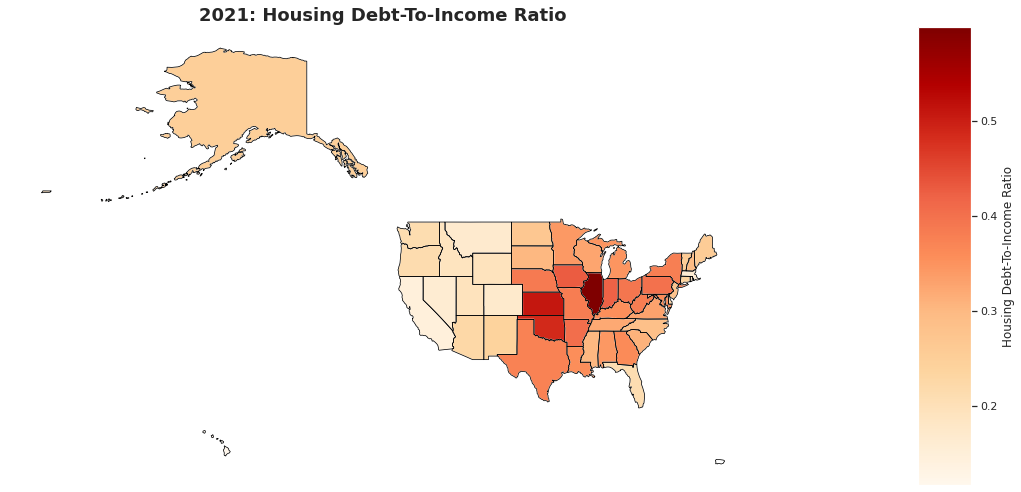

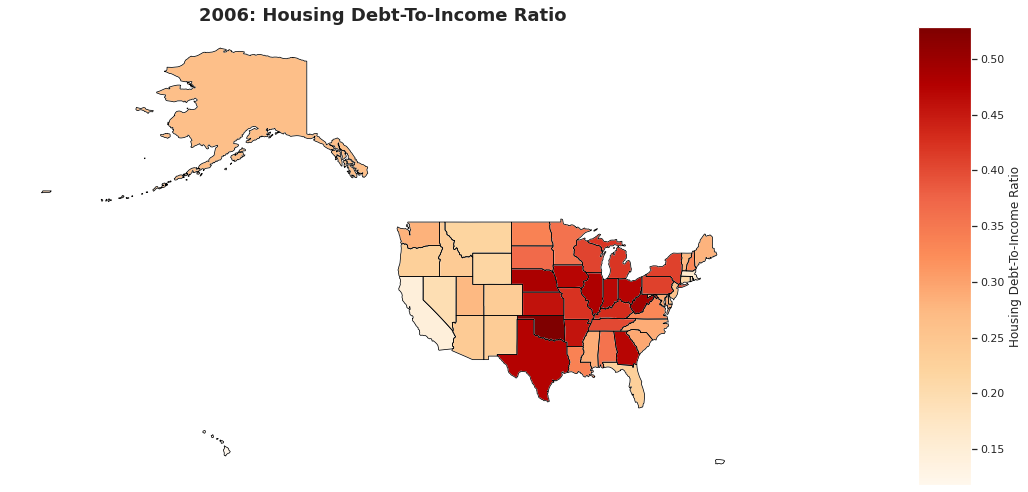

In [252]:
# Choropleth map of 2021
fig8, ax8 = plt.subplots(1,1, figsize=(20,9));

div = make_axes_locatable(ax8);

cax = div.append_axes("right", size="5%", pad=0.1);

iop.boundary.plot(edgecolor='black',  
                      linewidth=0.75,
                      ax=ax8);

iop.plot(column=2021,
        cmap='OrRd',
        legend=True,
        legend_kwds={'label': 'Housing Debt-To-Income Ratio'},
        cax=cax,
        ax=ax8);

ax8.axis('off');
ax8.set_title('2021: Housing Debt-To-Income Ratio', fontweight='bold', fontsize=18);

# Choropleth map of 2006
fig9, ax9 = plt.subplots(1,1, figsize=(20,9));

div = make_axes_locatable(ax9);

cax = div.append_axes("right", size="5%", pad=0.1);

iop.boundary.plot(edgecolor='black',  
                      linewidth=0.75,
                      ax=ax9);

iop.plot(column=2006,
        cmap='OrRd',
        legend=True,
        legend_kwds={'label': 'Housing Debt-To-Income Ratio'},
        cax=cax,
        ax=ax9);

ax9.axis('off');
ax9.set_title('2006: Housing Debt-To-Income Ratio', fontweight='bold', fontsize=18);


> The housing debt-to-income ratio is in general higher in 2006 than 2021. This is true particularly for southern regions like Texas, Oklahoma, and Georgia, as well as some midwest regions like Indiana, Iowa, and Ohio. There is a state in 2021 that has a slightly higher debt-to-income ratio than 2006-- Illinois. However, without digging deeper into the data it's hard to say if this is impacted by the housing market or not. Generally speaking, it appears we are in a better position with our debt-to-income ratio in terms of mortage in 2021 than we did in 2006.<br>
We can also see trends from these choropleth plots that align to our **income_over_prices_region** box-and-whisker plots. The midwest and southern region in general have a higher debt-to-income ratios than our 36% threshold value; while our west and other regions seem to fall below it.

## Results
Based on the data collected, cleaned and analyzed, from the Zillow ZHVI typical housing prices and the US Census median household income datasets, it is clear that the typical price of homes are unproportional to what the average American's household makes. Many banks and financial websites state, that individuals and families looking to purchase a home, should follow a 28% | 36% "rule of thumb". This "rule of thumb" states you should spend 28% or less of your monthly gross income on your mortgage payments, and no more than 36% of a household income should go towards **all** debt, *including* mortgage payments.<br>
From our <u>Median Household Income to Typical House Price Ratio by Region</u> box-and-whisker plot, we already know that not all Americans can follow this rule, even when we use the capped-off 36% ratio (this is assuming that these families have no other debt!).<br><br>
A housing bubble occurs when the price of homes rises at a rapid pace. Many things can cause a housing bubble like increase in demand, limited supply, and emotional spending. These bubbles are often fueled by prolonged periods of sub-normal interest rates and the race to purchase property. This phenomenon is called a "bubble" because at some point, it bursts. This is what happened in the 2008 Housing Market crash. The burst began in 2007 when interest rates began to climb, and property demand fell and then continued threw 2010.<br>
We chose to look at the housing debt-to-income ratio in 2006 because this was the peak of the housing bubble before it bursted. Comparing it to 2021, we can feel slightly better about where we are financially as a country because it appears Americans did not take out as much property debt as they did during the 2006 housing bubble. However, we should not sit too comfortably. There are many other factors that goes into a bubble burst / housing market crash that are not reflected on here, like interests rates, student debt, and the global economy as a whole.<br><br>
Some economists believe this bubble will not burst, and property values will continue to increase over the years without a sudden decline, and instead it will simply "correct" itself. Other economists do not believe this will be the case, as we finish 2022 interest rates have increased 2% - 3% since the beginning of the year, and houses are less likely to be sold more than their real worth.<br>
Overall, we will not truly know whether we are in a housing bubble until it bursts and the repercussions pass us. Regardless, the current typical price of a home for the average American is disproportionate to their income. This is an serious issue as many Americans could face financial disaster if or when a recession hits and the price of essential goods significantly rise, leaving them with tough financial choices.


## Suggested next steps
As highlight throughout this notebook, there are many factors that affect the housing market. Next steps that can be performed to get a better understanding of the current market goes as follows:
1. Integrating interest rates into the housing prices dataset
2. Research and understand the typical debt the average American faces (i.e. student loans)
3. Integrate these debts into the debt-to-income ratio touched upon this notebook
4. Improve this notebook by taking housing price sold data rather than Zillow ZHVI (because this takes the current economy into consideration in the typical housing prices)<br>

Other factors may be considered in this analysis that we did not touch upon. Real estate economics is a multi-faceted topic that is ever-growing and ever-changing. There will never be a perfect way to model and analyze it, but with these basic steps, we can gain an understanding of where are now and where we have been.

# References
We report here relevant references:
1. **Zillow**, [Zillow Home Value Index (ZHVI)](ps://files.zillowstatic.com/research/public_csvs/zhvi/Metro_zhvi_uc_sfrcondo_tier_0.33_0.67_month.csv?t=1664126527): Dataset we used for typical housing prices
2. **US Census**, [Historical Income Households](https://www2.census.gov/programs-surveys/cps/tables/time-series/historical-income-households/h08.xlsx): Dataset we used for household median income
3. **Longtermtrends**, [Home Price to Median Household Income Ratio (US)](https://www.longtermtrends.net/home-price-median-annual-income-ratio/): Inspiration for this project, drew upon its topics and ideas
4. **Bankrate**, [What is a housing bubble?](https://www.bankrate.com/real-estate/housing-bubble/): Understanding housing bubbles
5. **Bankrate**, [Is the housing market about to crash?](https://www.bankrate.com/real-estate/is-the-housing-market-about-to-crash/): Understanding current opinions on the housing market
6. **Investopedia**, [Debt-to-Income (DTI) Ratio](https://www.investopedia.com/terms/d/dti.asp): Understanding DTIs in the opinion of investors
7. **Chase**, [The effect of debt-to-income on your mortgage](https://www.chase.com/personal/mortgage/education/financing-a-home/debt-to-income-ratio#:~:text=A%20good%20rule%20of%20thumb,payments%20add%20up%20to%20%242%2C000.) Understanding DTIs in the opinions of banks
8. **Realtor**, [Do 'Flashing Red' Signs Mean That a U.S. Housing Bubble Will Soon Burst?](https://www.chase.com/personal/mortgage/education/financing-a-home/debt-to-income-ratio#:~:text=A%20good%20rule%20of%20thumb,payments%20add%20up%20to%20%242%2C000.): Opinions on current/future housing market